
Branin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=32119c52d5ec9b33ced3b96ff7e94428f1c55297b1097d6a3631a644c4047d6e
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1653147808.5247302

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248	 5.093418823776248
3	 [-3.98461003 13.27752775]	 4.8563413464393665	 4.8563413464393665	 5.0934172630199805	 5.093417389638316
4  	 [2.90441405 0.        ]	 6.7539396312344175	 4.8563413464393665	 4.861336358834948	 4.861335775812561
5  	 [ 5.33453311 15.        ]	 206.42079438319308	 4.85634134643

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745	 6.6922650079064745
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303	 6.692265007906303
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292	 1.684590944528292
4  	 [-2.58737971 14.70621645]	 15.699213344460711	 1.3984593420568778	 1.6845902571525213	 1.6845899715677868
5  	 [-4.49550966  0.        ]	 256.48774226320006	 1.398459

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891	 18.07886745449891
2	 [-5. 15.]	 17.508299515778166	 17.508299515778166	 18.078867447127802	 18.07886745449889
3	 [2.64338273 0.68243899]	 5.61793909734835	 5.61793909734835	 17.508263455635806	 17.508297463556392
4  	 [10.  0.]	 10.960889035651505	 5.61793909734835	 5.619312444097628	 5.619414311036591
5  	 [ 0.1797755 15.       ]	 105.60189349018982	 5.61793909734835	 5.61902933589552	 5.61938170000

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [ 1.25164457 13.57001383]	 100.61648848019335	 7.247126865776948	 7.24719790983207	 7.247197909829161
2  	 [-4.27198795  1.64727177]	 188.41076037632916	 7.247126865776948	 7.24719790983207	 7.247197409325942
3  	 [-4.64672604 10.91089036]	 37.1846450151111	 7.247126865776948	 7.247184557303612	 7.247196467425682
4  	 [3.91212467 8.49902465]	 48.6487300672887	 7.247126865776948	 7.247008561718002	 7.247185997506159
5  	 [1.25493841 0.        ]	 30.67444153386182	 7.247126865776948	 7.24

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746	 5.961907098265746
3  	 [-4.14000513  7.24507321]	 61.92440283609248	 5.96108856337545	 5.96190691908924	 5.961905562171253
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642882632	 5.961890642882632
5  	 [3.90181696 0.        ]	 6.127848921392869	 5.96108856337545	 5.961858176611

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [ 9.64829531 12.55362889]	 98.32295673962142	 15.31731051317483	 15.31731050317483	 15.317310503173594
2  	 [-1.22578785  0.62063252]	 69.8637190838968	 15.31731051317483	 15.317310503174827	 15.317310503035172
3  	 [ 4.11366027 15.        ]	 183.1048389331307	 15.31731051317483	 15.317309419243767	 15.317309952767742
4	 [-2.6674426  14.57038303]	 13.056901966381519	 13.056901966381519	 15.317269932604527	 15.317309278848978
5  	 [-5.          4.21701969]	 180.9534809476149	 13.05690196

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922	 5.214210673253922
2  	 [ 7.42679792 14.12713902]	 178.37635728719692	 5.211335324193094	 5.21421067254134	 5.214210654642059
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393	 5.214210312347393
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922	 5.214210673253922
5  	 [4.57397832 5.89851842]	 28.70553793307401	 5.211335324193094	

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238	 15.416245458468238
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392	 6.499606274426392
3  	 [ 1.38513666 12.68478345]	 86.44703914953044	 6.499298445992174	 6.499605162879605	 6.499605288146548
4  	 [-5.          4.93661841]	 162.80442284717998	 6.499298445992174	 6.499603335514514	 6.499605170764445
5  	 [4.45940914 1.25808388]	 7.642291015243577	 6.499298445992

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876	 3.497841782110876
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054	 3.4978417820600054
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437	 3.497841747459437
4  	 [7.59806604 8.71640602]	 66.4707880179505	 3.4640248583909496	 3.497841027786867	 3.4978407526784863
5  	 [1.75682087 9.14350645]	 38.925142112148194	 3.4640248

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652	 2.791471383796652
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415	 2.7914713837968415
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637	 2.7914713830067637
4  	 [ 1.02007318 14.99165265]	 124.87045185818938	 2.710610964564512	 2.791469974671166	 2.791469986599886
5  	 [-5. 15.]	 17.508299515778166	 2.710610964564512	 2.790453

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117	 22.374358429523117
2	 [9.97678471 6.82121545]	 16.579038540907792	 16.579038540907792	 17.615402322258053	 17.61540229548113
3  	 [-5. 15.]	 17.508299515778166	 16.579038540907792	 16.578290426963814	 16.579038530900622
4	 [2.40801211 2.48954713]	 3.0501065715386115	 3.0501065715386115	 16.578736321631148	 16.57881130494394
5  	 [ 4.54065244 15.        ]	 192.31967206318836	 3.0501065715386115	 3.104

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.          4.42107276]	 3.954194082047561	 0.5499315281120278	 1.1031910701027643	 1.1032403834133084
2  	 [ 8.50155249 13.79797306]	 148.00655208378976	 0.5499315281120278	 1.1028242099285575	 1.1028242099285575
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575	 1.1028242099285575
4  	 [4.42596068 8.80636112]	 60.867843958780504	 0.5499315281120278	 1.1028241571796265	 1.1028231607553032
5  	 [3.16550125 0.59293366]	 3.167846705464953

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.         10.55852118]	 56.66525878591633	 18.038943061558626	 18.038943051558626	 18.038943051558626
2  	 [-3.36042638  1.3238031 ]	 132.49290788011677	 18.038943061558626	 18.038943051558626	 18.038943051558626
3  	 [-0.52982392  6.71014619]	 18.314307626651804	 18.038943061558626	 18.038942283310924	 18.03894164119828
4  	 [-0.84263662 15.        ]	 73.65233828643677	 18.038943061558626	 18.03894212067189	 18.038942202784675
5	 [2.38932607 0.        ]	 11.60195863688191	 

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [10.          6.86146309]	 16.831212994433713	 1.4149920024014744	 1.6971407473891316	 1.6971407473955233
2  	 [-3.61083748  7.85924032]	 32.481990179851884	 1.4149920024014744	 1.6971407472739075	 1.6971407472739075
3  	 [-2.0612189   2.20166702]	 63.659546047406224	 1.4149920024014744	 1.6971399322648641	 1.6971391830257423
4  	 [10.         14.31835377]	 129.98135367090563	 1.4149920024014744	 1.6964206973321694	 1.6971407474679343
5  	 [5.68735483 7.81784087]	 62.71624021060057

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [ 6.5655417  11.87699252]	 134.95011349993544	 12.768724532005583	 12.768724522031357	 12.768724522031354
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418	 12.768724521196418
3  	 [ 0.69560056 15.        ]	 118.2647397959169	 12.768724532005583	 12.768724257475103	 12.768723486479509
4	 [2.88475658 0.        ]	 6.88220071543949	 6.88220071543949	 12.768719017065422	 12.768721669293681
5  	 [10.          7.39042898]	 21.193054520204576

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577	 2.7962650410643577
2  	 [9.4202829  9.76772141]	 53.637049482645274	 2.715864006988424	 2.796264877786649	 2.796264377546995
3  	 [-4.0224718  0.       ]	 213.9124926483157	 2.715864006988424	 2.796264881445826	 2.79626295429485
4  	 [3.7651238  8.42514946]	 45.58269801941948	 2.715864006988424	 2.7962616857843754	 2.7962619463515272
5  	 [10.  0.]	 10.960889035651505	 2.715864006988424	 2.79572652178

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [10.  0.]	 10.960889035651505	 10.960889035651505	 19.016141107164255	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 10.960889035651505	 10.960889028171572	 10.960889028171572
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 10.960888555533685	 10.96088841225565
4  	 [10.        14.8139203]	 141.4420041115163	 2.3563457989420957	 2.4736666897768274	 2.473666214104198
5  	 [-5.         11.27052857]	 47.73264903616691	 2.3563457989420957	 2.

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543	 8.150085433802543
2  	 [-5.          4.87248437]	 164.37991510154717	 8.150075223157177	 8.150083903898924	 8.150084362882067
3  	 [ 0.52323371 11.06521766]	 52.68753582617826	 8.150075223157177	 8.150044699607788	 8.150066047979948
4	 [4.17694426 0.        ]	 7.6801763668129635	 7.6801763668129635	 8.150029646542308	 8.150029608571426
5  	 [10. 15.]	 145.87219087939556	 7.6801763668129635	 7.6802050

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809	 4.484380377136809
2  	 [4.37628552 4.97685259]	 18.858765747109825	 0.8198597583535783	 1.2739300535480347	 1.2739297489168748
3  	 [-5.          6.34816407]	 130.211922193344	 0.8198597583535783	 1.273927450041542	 1.2739274494041752
4  	 [ 0.06647119 15.        ]	 102.48596403888756	 0.8198597583535783	 1.2739245602588851	 1.273924545207315
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.27

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-0.46336714  1.1335069 ]	 50.30566093512107	 14.042667401507376	 14.042667391507678	 14.042666417442472
2	 [10.        6.031178]	 11.113265474397442	 11.113265474397442	 14.042666918411728	 14.042667222267836
3	 [9.66690311 0.        ]	 7.896928758531159	 7.896928758531159	 11.113262512176822	 11.113264373978426
4  	 [-2.95535785 15.        ]	 10.600694479024181	 7.896928758531159	 7.896946684292896	 7.896946680117831
5  	 [-5.         4.7060363]	 168.50719457770535	 7.8969287

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1653148921.66169

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.25533007 10.8048674 ]	 56.52874004692151	 27.68166689936483	    	    
init	 [-4.99828438  4.53498859]	 172.66531086516164	 27.68166689936483	    	    
init	 [-2.79866164  1.38507892]	 102.58290348816024	 27.68166689936483	    	    
init	 [-2.20609683  5.18341091]	 28.868064601155666	 27.68166689936483	    	    
init	 [0.95151211 8.08225101]	 27.68166689936483	 27.68166689936483	    	    
1	 [8.41909995 1.27566317]	 5.089934878453152	 5.089934878453152	 27.68166688936483	 27.68166688936483
2  	 [ 8.98893195 10.45227242]	 70.52424256621515	 5.089934878453152	 5.093418823776248	 5.093418823776248
3  	 [3.1784986 0.       ]	 5.450714203742865	 5.089934878453152	 5.0934172630199805	 5.093417389638316
4  	 [-4.67712792 14.21955317]	 13.865244792739254	 5.089934878453152	 5.0934188219075285	 5.0934188219075285
5  	 [ 5.30676004 15.        ]	 206.03558952485747	 5.089934878453

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.53992353 0.38889348]	 22.31361308916297	 6.692051508754487	    	    
init	 [3.24493717 6.52983589]	 19.233109967858276	 6.692051508754487	    	    
init	 [1.30551703 4.95502232]	 13.177851563387286	 6.692051508754487	    	    
init	 [-1.93027049  9.2890645 ]	 6.692051508754487	 6.692051508754487	    	    
init	 [-0.50517989  4.00240913]	 26.437522758780958	 6.692051508754487	    	    
1  	 [ 9.5587047  12.00387527]	 89.09951357262268	 6.692051508754487	 6.6922650079064745	 6.6922650079064745
2	 [9.59366035 1.69164323]	 1.3984593420568778	 1.3984593420568778	 6.692265007906303	 6.692265007906303
3  	 [ 3.24245232 12.67669673]	 110.25694222671481	 1.3984593420568778	 1.684590944528292	 1.684590944528292
4  	 [-5.          0.47652372]	 291.9758016736889	 1.3984593420568778	 1.6845902571525213	 1.6845899715677868
5  	 [9.02917984 6.38725122]	 18.99628463361546	 1.3984593420

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.26196854 10.62221734]	 71.68783452098575	 18.07886746449891	    	    
init	 [-0.63642892  7.66241408]	 18.07886746449891	 18.07886746449891	    	    
init	 [ 8.39420432 13.44439633]	 141.98653529865882	 18.07886746449891	    	    
init	 [-3.11622034  3.10864317]	 83.31045707266176	 18.07886746449891	    	    
init	 [-4.22799195  6.61214765]	 76.5294170688398	 18.07886746449891	    	    
1  	 [6.70472147 4.59545299]	 30.726791812855225	 18.07886746449891	 18.07886745449891	 18.07886745449891
2	 [-3.89564496 13.38589781]	 3.6010193697779265	 3.6010193697779265	 18.078867447127802	 18.07886745449889
3  	 [ 0.53511805 15.        ]	 114.58765716763713	 3.6010193697779265	 3.62945032452176	 3.629531877334344
4  	 [3.11133413 0.        ]	 5.686376470456184	 3.6010193697779265	 3.629533318036846	 3.629532497660855
5  	 [9.70346787 8.50929412]	 34.28297118578492	 3.601019369777

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.50544759 8.20848374]	 32.51676744781521	 7.247126865776948	    	    
init	 [ 9.5902654  10.72223991]	 66.20566674364716	 7.247126865776948	    	    
init	 [5.46593237 3.24134243]	 20.90089401680587	 7.247126865776948	    	    
init	 [9.64411682 0.09345383]	 7.247126865776948	 7.247126865776948	    	    
init	 [-1.20526456  6.52187299]	 15.941376982363263	 7.247126865776948	    	    
1  	 [-5.  0.]	 308.12909601160663	 7.247126865776948	 7.24719790983207	 7.247197909829161
2  	 [ 1.1294018  14.15696259]	 109.93986979623045	 7.247126865776948	 7.247197909835409	 7.247197909835409
3  	 [1.01107069 0.        ]	 35.554826707809156	 7.247126865776948	 7.24719303389414	 7.247196599176173
4  	 [3.23218268 8.99706827]	 46.56384602934775	 7.247126865776948	 7.247168110546214	 7.247197733624095
5  	 [-4.71931664 12.72607102]	 23.47782987479111	 7.247126865776948	 7.247197172880776

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.67010243 13.06098459]	 25.390690545664548	 25.311309190989615	    	    
init	 [-1.89921267 13.77916362]	 25.311309190989615	 25.311309190989615	    	    
init	 [2.32616783 9.17615794]	 41.60147975414021	 25.311309190989615	    	    
init	 [6.48861785 7.77626982]	 63.81281921768236	 25.311309190989615	    	    
init	 [-0.54799248  2.81581843]	 34.966203644931994	 25.311309190989615	    	    
1	 [8.84124421 0.03321319]	 5.96108856337545	 5.96108856337545	 25.311309180989422	 25.311309180989422
2  	 [ 8.39476442 14.47736321]	 167.21523769473345	 5.96108856337545	 5.961907098265746	 5.961907098265746
3  	 [-5.          8.10986515]	 95.12466680670255	 5.96108856337545	 5.96190691908924	 5.961905562171253
4  	 [-5.  0.]	 308.12909601160663	 5.96108856337545	 5.961890642966492	 5.961890642966492
5  	 [4.68041959 2.64376529]	 11.288061329654056	 5.96108856337545	 5.96185817660

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.39290227 4.97969708]	 15.553860636684597	 15.31731051317483	    	    
init	 [7.31843685 0.62544939]	 15.31731051317483	 15.31731051317483	    	    
init	 [-3.3851498   8.92578096]	 16.222288919361837	 15.31731051317483	    	    
init	 [2.94726043 6.28211143]	 15.406373581304088	 15.31731051317483	    	    
init	 [0.03111774 9.33779148]	 31.07053245856209	 15.31731051317483	    	    
1  	 [10. 15.]	 145.87219087939556	 15.31731051317483	 15.31731050317483	 15.317310503173594
2  	 [-2.67838097  0.        ]	 126.61486786700603	 15.31731051317483	 15.317310503174827	 15.317310503035172
3  	 [ 4.34724927 14.59608757]	 177.48889452505895	 15.31731051317483	 15.31731050317483	 15.31731050317483
4  	 [-1.30746846 14.41632538]	 49.88755953556025	 15.31731051317483	 15.317284392562508	 15.3173092935115
5  	 [8.13676748 9.89528697]	 76.08522805324013	 15.31731051317483	 15.3172385

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.85537566 11.69878188]	 8.299317850233932	 5.211335324193094	    	    
init	 [ 1.57613847 10.85197767]	 59.50408380701259	 5.211335324193094	    	    
init	 [9.66984268 8.07743806]	 29.714921414987273	 5.211335324193094	    	    
init	 [2.51680695 1.080767  ]	 5.211335324193094	 5.211335324193094	    	    
init	 [-0.9734153   7.49823751]	 15.431057204948033	 5.211335324193094	    	    
1  	 [-4.97859679  1.38393519]	 260.3293952774437	 5.211335324193094	 5.214210673253922	 5.214210673253922
2  	 [ 7.80155495 14.72615764]	 186.86153570538508	 5.211335324193094	 5.21421067254134	 5.214210654642059
3  	 [8.08940775 0.35854539]	 9.249625108410735	 5.211335324193094	 5.214210312347393	 5.214210312347393
4  	 [-3.39684884  5.54228873]	 54.79871094423047	 5.211335324193094	 5.214210673253922	 5.214210673253922
5  	 [4.93717413 5.49891249]	 29.845086555570777	 5.211335324193094

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.10144104 14.52810994]	 175.17297136347514	 15.416245468470875	    	    
init	 [8.0379181  7.96283537]	 49.32173799887473	 15.416245468470875	    	    
init	 [-1.50907508  0.17098206]	 83.26753461673219	 15.416245468470875	    	    
init	 [1.45703227 6.0352704 ]	 15.416245468470875	 15.416245468470875	    	    
init	 [2.84012007 7.17587694]	 22.49093277852639	 15.416245468470875	    	    
1	 [9.77124156 0.43098073]	 6.499298445992174	 6.499298445992174	 15.416245458468238	 15.416245458468238
2  	 [-4.87537438 11.82874897]	 36.57081146531108	 6.499298445992174	 6.499606274426392	 6.499606274426392
3  	 [-0.06146391 15.        ]	 98.82405002647226	 6.499298445992174	 6.499605162879605	 6.499605288146548
4  	 [4.4595038 0.8533709]	 7.979766606771776	 6.499298445992174	 6.499603335514521	 6.499605170764445
5  	 [-5.         6.0933586]	 135.8006206439636	 6.499298445992174	 

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-4.84438769  7.52811888]	 96.15564306553264	 3.4640248583909496	    	    
init	 [2.4365994  2.00744293]	 3.4640248583909496	 3.4640248583909496	    	    
init	 [-2.86833372  3.27838013]	 70.46930174488207	 3.4640248583909496	    	    
init	 [1.27762271 3.72151753]	 12.982825924833865	 3.4640248583909496	    	    
init	 [-3.73910523  5.1824796 ]	 75.58547400560856	 3.4640248583909496	    	    
1  	 [ 7.05609655 14.75038872]	 200.4388688685465	 3.4640248583909496	 3.497841782110876	 3.497841782110876
2  	 [-0.46054038 14.56197292]	 79.4666617606301	 3.4640248583909496	 3.4978417820600054	 3.4978417820600054
3  	 [8.28747407 1.2035024 ]	 6.196385269800155	 3.4640248583909496	 3.497841747459437	 3.497841747459437
4  	 [4.57208176 9.16642126]	 68.60581850295517	 3.4640248583909496	 3.497841027786867	 3.4978407526784863
5  	 [10.          6.41094566]	 13.557530071759565	 3.4640

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.56980965 0.31127924]	 19.863985024602144	 2.710610964564512	    	    
init	 [ 4.50472352 11.23205824]	 103.66999147252169	 2.710610964564512	    	    
init	 [2.47760518 3.37194968]	 2.710610964564512	 2.710610964564512	    	    
init	 [-2.02905703 11.40796068]	 8.463930835255017	 2.710610964564512	    	    
init	 [-2.46333745  1.32509721]	 90.49481266026973	 2.710610964564512	    	    
1  	 [ 9.16391068 14.81438212]	 158.2412724465548	 2.710610964564512	 2.791471383796652	 2.791471383796652
2  	 [9.65621089 6.61160737]	 16.1339423373336	 2.710610964564512	 2.7914713837968415	 2.7914713837968415
3  	 [-3.43070383  6.59407857]	 41.58407101130534	 2.710610964564512	 2.7914713830067637	 2.7914713830067637
4  	 [ 0.96819077 15.        ]	 124.01518097118615	 2.710610964564512	 2.791469974671166	 2.791469986599886
5  	 [5.26562048 6.20098174]	 40.041421370769086	 2.71061096456

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.29595467  0.29212862]	 104.49282729548965	 22.37435843952312	    	    
init	 [ 1.9482779  10.87400894]	 62.47758067812407	 22.37435843952312	    	    
init	 [1.30305407 7.28140647]	 22.37435843952312	 22.37435843952312	    	    
init	 [-4.80828778  7.31057411]	 97.94503054415523	 22.37435843952312	    	    
init	 [ 9.12709979 12.76192634]	 111.62900800771942	 22.37435843952312	    	    
1	 [6.94653631 0.95529646]	 17.615403152614682	 17.615403152614682	 22.374358429523117	 22.374358429523117
2	 [9.28738882 6.14578118]	 14.808790749874726	 14.808790749874726	 17.615402322258053	 17.61540229548113
3	 [2.54385739 0.04476512]	 9.58430283129103	 9.58430283129103	 14.808015906178486	 14.808790739867575
4  	 [ 4.54043559 15.        ]	 192.31515921238574	 9.58430283129103	 9.583961681286047	 9.58430314063196
5	 [-2.78845701 11.96288645]	 1.2612701228696341	 1.2612701228696341	

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-2.68755736 11.10074545]	 1.3827702760021356	 0.5499315281120278	    	    
init	 [-1.05027477  8.0060909 ]	 14.81231853080056	 0.5499315281120278	    	    
init	 [-4.78137556 13.78120512]	 18.401131000214548	 0.5499315281120278	    	    
init	 [8.51072281 0.50132141]	 5.855172364344769	 0.5499315281120278	    	    
init	 [9.35424004 2.05813982]	 0.5499315281120278	 0.5499315281120278	    	    
1  	 [10.         4.2917554]	 3.604142984594371	 0.5499315281120278	 1.1031910701027643	 1.1032403834133084
2  	 [ 9.19833734 12.85785838]	 112.3096138370831	 0.5499315281120278	 1.1028242099285575	 1.1028242099285575
3  	 [-4.8799499   0.15657603]	 290.0404981832191	 0.5499315281120278	 1.1028242099285575	 1.1028242099285575
4  	 [2.31082274 1.96051811]	 4.630930870259078	 0.5499315281120278	 1.1028242068712346	 1.1028241580784406
5  	 [4.84411484 8.7761414 ]	 66.82952699849903	 0.

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.66553616 3.5631183 ]	 24.823670200298267	 18.038943061558626	    	    
init	 [ 7.36417799 14.48623797]	 188.7803334745195	 18.038943061558626	    	    
init	 [9.58901671 6.80173871]	 18.038943061558626	 18.038943061558626	    	    
init	 [ 4.13563694 11.63289772]	 104.87319703906111	 18.038943061558626	    	    
init	 [ 4.62420017 10.83027344]	 98.03271225790056	 18.038943061558626	    	    
1  	 [-5.  0.]	 308.12909601160663	 18.038943061558626	 18.038943051558626	 18.038943051558626
2	 [-3.06562888 11.40851515]	 0.8943531028899869	 0.8943531028899869	 18.038943051335508	 18.038943051558626
3  	 [-0.77721745  5.55115316]	 19.956248293009427	 0.8943531028899869	 1.3235330933561291	 1.3235330933561291
4  	 [-0.24948802 15.        ]	 93.17689500314201	 0.8943531028899869	 1.3235177097998942	 1.323531445656268
5  	 [2.24297905 0.        ]	 13.507883026233038	 0.89435310288

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.70915016 11.59747578]	 81.58264375064097	 1.4149920024014744	    	    
init	 [8.05641529 0.12070423]	 10.148649076616518	 1.4149920024014744	    	    
init	 [-0.35396112 14.36405609]	 79.6056658956529	 1.4149920024014744	    	    
init	 [2.69675068 4.77426637]	 5.855607664288365	 1.4149920024014744	    	    
init	 [3.08799906 3.31882414]	 1.4149920024014744	 1.4149920024014744	    	    
1  	 [-4.22572169  4.73878507]	 111.46482334173054	 1.4149920024014744	 1.6971407473891316	 1.6971407473955233
2  	 [ 9.02510452 14.92575454]	 164.15736583327134	 1.4149920024014744	 1.6971407472101587	 1.6971407472101587
3  	 [8.4415984  6.61360555]	 28.132050221972662	 1.4149920024014744	 1.6971407168951451	 1.6971407168951451
4  	 [-0.6348753  0.       ]	 67.61008168553072	 1.4149920024014744	 1.6971390234773085	 1.6971390412792724
5  	 [-2.40015779  9.60941637]	 3.8299944025381123	 

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [7.73226546 2.68343887]	 12.768724532005583	 12.768724532005583	    	    
init	 [-4.18455179  5.42307669]	 95.39334176626551	 12.768724532005583	    	    
init	 [-0.86898607  7.95000337]	 16.419487782111716	 12.768724532005583	    	    
init	 [-0.41121626  4.56711539]	 23.250362743740954	 12.768724532005583	    	    
init	 [-3.32388086  3.74848521]	 80.99796277938532	 12.768724532005583	    	    
1  	 [10. 15.]	 145.87219087939556	 12.768724532005583	 12.768724522031357	 12.768724522031354
2  	 [-4.77493765 13.49591113]	 19.896906503438096	 12.768724532005583	 12.768724521196418	 12.768724521196418
3  	 [ 3.80261319 11.96078244]	 105.3381651976412	 12.768724532005583	 12.76872447075339	 12.76872447075339
4  	 [8.63272613 8.32488519]	 44.68998814179533	 12.768724532005583	 12.768723384052656	 12.768723384052656
5	 [2.63098807 0.01106722]	 8.890052611403327	 8.89005261140332

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-1.65063381  7.84745012]	 10.514702126319445	 2.715864006988424	    	    
init	 [3.26052185 0.68402925]	 2.715864006988424	 2.715864006988424	    	    
init	 [0.41093253 3.34621413]	 22.889515127492515	 2.715864006988424	    	    
init	 [5.33089243 2.45597138]	 17.178157611778595	 2.715864006988424	    	    
init	 [-3.945127  14.1151629]	 3.3649224341694195	 2.715864006988424	    	    
1  	 [ 5.63879248 14.58068289]	 198.51319639462758	 2.715864006988424	 2.7962650410643577	 2.7962650410643577
2  	 [-5.          0.76360453]	 282.4634960240413	 2.715864006988424	 2.796264877786649	 2.796264377546995
3  	 [6.4086727  8.01053377]	 67.19879991173286	 2.715864006988424	 2.796264138365111	 2.796265038345444
4  	 [ 1.37630907 11.42929673]	 66.24718744041212	 2.715864006988424	 2.7961126043039553	 2.79625796461
5  	 [-5.         10.21600199]	 61.323587189474544	 2.715864006988424

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-0.58002496  7.95880133]	 19.016141117164256	 19.016141117164256	    	    
init	 [-2.1271882   1.01850537]	 85.05949339404415	 19.016141117164256	    	    
init	 [6.8047819  9.84500283]	 93.89792695202516	 19.016141117164256	    	    
init	 [4.56281344 8.63404341]	 60.50217141122736	 19.016141117164256	    	    
init	 [-4.41405626  5.36720407]	 110.70834086593878	 19.016141117164256	    	    
1	 [9.76575296 0.98553483]	 4.1623278326263815	 4.1623278326263815	 19.016141107164255	 19.016141107164255
2  	 [-0.36591853 14.49945231]	 81.3728947682288	 4.1623278326263815	 4.175953248370189	 4.175953248370189
3	 [3.74599703 2.35814314]	 2.3563457989420957	 2.3563457989420957	 4.175952634281328	 4.17595270828156
4  	 [10.         14.92965946]	 144.18938157396997	 2.3563457989420957	 2.4736666897768274	 2.473666214104198
5  	 [9.39679852 5.53959908]	 9.938002284241987	 2.356345798

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [4.75561363 7.58180061]	 49.215059064668324	 8.150075223157177	    	    
init	 [8.17902206 2.72760338]	 8.150075223157177	 8.150075223157177	    	    
init	 [ 7.78349603 11.25204429]	 106.98107856533271	 8.150075223157177	    	    
init	 [ 4.99152501 14.81843172]	 196.08601750690153	 8.150075223157177	    	    
init	 [-1.14547366  0.42458888]	 71.23649635555944	 8.150075223157177	    	    
1  	 [-4.83474958 11.77354131]	 35.58412906267954	 8.150075223157177	 8.150085433802543	 8.150085433802543
2  	 [-1.31027796  6.26018244]	 16.663442406570503	 8.150075223157177	 8.150083903898924	 8.150084362882067
3  	 [ 0.35908684 11.68414639]	 57.91470988730182	 8.150075223157177	 8.150043865074647	 8.150058990495566
4	 [4.16866889 0.        ]	 7.625670656251107	 7.625670656251107	 8.15002964654158	 8.150029607943807
5  	 [10. 15.]	 145.87219087939556	 7.625670656251107	 7.62570288504

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [-3.53699597 11.41874575]	 4.475608269502271	 4.475608269502271	    	    
init	 [-1.2959304   2.07197531]	 51.13947793770689	 4.475608269502271	    	    
init	 [-0.02830155  1.24499348]	 42.63973921760034	 4.475608269502271	    	    
init	 [ 5.07965622 12.09890697]	 131.17235664506808	 4.475608269502271	    	    
init	 [9.74112872 9.53491102]	 46.84458913925112	 4.475608269502271	    	    
1	 [9.57054653 2.03489665]	 0.8198597583535783	 0.8198597583535783	 4.484380377136809	 4.484380377136809
2  	 [5.03077312 4.64729248]	 24.460797393473307	 0.8198597583535783	 1.2739300535480347	 1.2739297489168748
3  	 [0.20107266 7.62370777]	 23.16644757636532	 0.8198597583535783	 1.273927588153038	 1.2739274495316375
4  	 [ 0.09562252 15.        ]	 103.29917138491766	 0.8198597583535783	 1.2739245602064833	 1.2739245579113374
5  	 [10. 15.]	 145.87219087939556	 0.8198597583535783	 1.27

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 3.82196202 13.46570592]	 138.5264349938869	 14.042667401507376	    	    
init	 [ 8.37296094 12.23756216]	 115.63178540512689	 14.042667401507376	    	    
init	 [-4.46165622 10.37636373]	 35.66708529307584	 14.042667401507376	    	    
init	 [0.68021413 7.77766418]	 25.307769914281764	 14.042667401507376	    	    
init	 [4.86927198 2.90775327]	 14.042667401507376	 14.042667401507376	    	    
1  	 [-5.  0.]	 308.12909601160663	 14.042667401507376	 14.042667391507678	 14.042666417442472
2	 [10.          5.49820193]	 8.169389869926185	 8.169389869926185	 14.042666918413207	 14.042667212155465
3  	 [0.61138061 0.18064926]	 41.819817406212465	 8.169389869926185	 8.169357898860278	 8.169398334878176
4  	 [-1.2637238 15.       ]	 58.903560875286885	 8.169389869926185	 8.169399645127884	 8.16939964098686
5  	 [-4.79483707  5.40415968]	 136.16520405222172	 8.169389869926185	 8.1

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


1093.0744590759277

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.6590331517653232, 1.5897370822421468)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.5857547920775205, 0.35192473718351774)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(1.2866105374434376, 1.3860209161817125)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-0.013754104128034628, 0.2872135780723568)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.1445131454769801, -0.19866740723405696)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-0.05704718678579214, 0.37010063854559794)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(1.0959866817408224, 1.1083347504860048)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.9311134220088308, 1.4027284177430812)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.9546617165499978, 1.1961845526879693)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.9667465536186262, 0.8831672534450093)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.32919431112512837, 0.4992663894250623)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.05359222109358334, -0.05359222109358334)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.8893914120429847, -0.0558952616430456)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.5949161906605641, 0.5949161906605641)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.34934510149634, 1.1129763185740422)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.1358281109947383, 1.1358281109947383)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.8820705683536354, 0.8104034599570697)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.836144725581267, 1.2460942537685253)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-0.19143071244374404, 0.1970022317043208)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.723788825547703, 0.8543371351674605)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

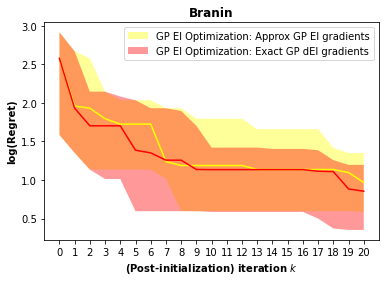

In [143]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(1113.1368563175201, 1093.0744590759277)

In [100]:
min_ei = 0


In [101]:
### acqFunc regret minimization: run number = 1

### Exact
acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history) 
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

acqFuncApproxRegret_exact_1 = np.log(acqFuncApprox_exact_1 - min_ei)
acqFuncExactRegret_exact_1 = np.log(acqFuncExact_exact_1 - min_ei)

acqFuncApproxSimpleRegret_exact_1 = min_max_array(acqFuncApproxRegret_exact_1)
acqFuncExactSimpleRegret_exact_1 = min_max_array(acqFuncExactRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1 = min(acqFuncApproxSimpleRegret_exact_1)
min_acqFuncExactSimpleRegret_exact_1 = min(acqFuncExactSimpleRegret_exact_1)

min_acqFuncApproxSimpleRegret_exact_1, min_acqFuncExactSimpleRegret_exact_1


(1.3855799132881188, 1.2053714728428178)

In [102]:
### acqFunc regret minimization: run number = 2

### Exact
acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history) 
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

acqFuncApproxRegret_exact_2 = np.log(acqFuncApprox_exact_2 - min_ei)
acqFuncExactRegret_exact_2 = np.log(acqFuncExact_exact_2 - min_ei)

acqFuncApproxSimpleRegret_exact_2 = min_max_array(acqFuncApproxRegret_exact_2)
acqFuncExactSimpleRegret_exact_2 = min_max_array(acqFuncExactRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2 = min(acqFuncApproxSimpleRegret_exact_2)
min_acqFuncExactSimpleRegret_exact_2 = min(acqFuncExactSimpleRegret_exact_2)

min_acqFuncApproxSimpleRegret_exact_2, min_acqFuncExactSimpleRegret_exact_2


(0.17849865736472914, 0.035944564146014026)

In [103]:
### acqFunc regret minimization: run number = 3

### Exact
acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history) 
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

acqFuncApproxRegret_exact_3 = np.log(acqFuncApprox_exact_3 - min_ei)
acqFuncExactRegret_exact_3 = np.log(acqFuncExact_exact_3 - min_ei)

acqFuncApproxSimpleRegret_exact_3 = min_max_array(acqFuncApproxRegret_exact_3)
acqFuncExactSimpleRegret_exact_3 = min_max_array(acqFuncExactRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3 = min(acqFuncApproxSimpleRegret_exact_3)
min_acqFuncExactSimpleRegret_exact_3 = min(acqFuncExactSimpleRegret_exact_3)

min_acqFuncApproxSimpleRegret_exact_3, min_acqFuncExactSimpleRegret_exact_3


(1.0150094356391726, 0.9135822343278432)

In [104]:
### acqFunc regret minimization: run number = 4

### Exact
acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history) 
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

acqFuncApproxRegret_exact_4 = np.log(acqFuncApprox_exact_4 - min_ei)
acqFuncExactRegret_exact_4 = np.log(acqFuncExact_exact_4 - min_ei)

acqFuncApproxSimpleRegret_exact_4 = min_max_array(acqFuncApproxRegret_exact_4)
acqFuncExactSimpleRegret_exact_4 = min_max_array(acqFuncExactRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4 = min(acqFuncApproxSimpleRegret_exact_4)
min_acqFuncExactSimpleRegret_exact_4 = min(acqFuncExactSimpleRegret_exact_4)

min_acqFuncApproxSimpleRegret_exact_4, min_acqFuncExactSimpleRegret_exact_4


(-0.021768240773877897, -0.09058897402212854)

In [105]:
### acqFunc regret minimization: run number = 5

### Exact
acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history) 
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

acqFuncApproxRegret_exact_5 = np.log(acqFuncApprox_exact_5 - min_ei)
acqFuncExactRegret_exact_5 = np.log(acqFuncExact_exact_5 - min_ei)

acqFuncApproxSimpleRegret_exact_5 = min_max_array(acqFuncApproxRegret_exact_5)
acqFuncExactSimpleRegret_exact_5 = min_max_array(acqFuncExactRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5 = min(acqFuncApproxSimpleRegret_exact_5)
min_acqFuncExactSimpleRegret_exact_5 = min(acqFuncExactSimpleRegret_exact_5)

min_acqFuncApproxSimpleRegret_exact_5, min_acqFuncExactSimpleRegret_exact_5


(-0.044882106888088, -0.2464298236228305)

In [106]:
### acqFunc regret minimization: run number = 6

### Exact
acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history) 
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

acqFuncApproxRegret_exact_6 = np.log(acqFuncApprox_exact_6 - min_ei)
acqFuncExactRegret_exact_6 = np.log(acqFuncExact_exact_6 - min_ei)

acqFuncApproxSimpleRegret_exact_6 = min_max_array(acqFuncApproxRegret_exact_6)
acqFuncExactSimpleRegret_exact_6 = min_max_array(acqFuncExactRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6 = min(acqFuncApproxSimpleRegret_exact_6)
min_acqFuncExactSimpleRegret_exact_6 = min(acqFuncExactSimpleRegret_exact_6)

min_acqFuncApproxSimpleRegret_exact_6, min_acqFuncExactSimpleRegret_exact_6


(0.17512106331439622, -0.4318912932119368)

In [107]:
### acqFunc regret minimization: run number = 7

### Exact
acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history) 
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

acqFuncApproxRegret_exact_7 = np.log(acqFuncApprox_exact_7 - min_ei)
acqFuncExactRegret_exact_7 = np.log(acqFuncExact_exact_7 - min_ei)

acqFuncApproxSimpleRegret_exact_7 = min_max_array(acqFuncApproxRegret_exact_7)
acqFuncExactSimpleRegret_exact_7 = min_max_array(acqFuncExactRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7 = min(acqFuncApproxSimpleRegret_exact_7)
min_acqFuncExactSimpleRegret_exact_7 = min(acqFuncExactSimpleRegret_exact_7)

min_acqFuncApproxSimpleRegret_exact_7, min_acqFuncExactSimpleRegret_exact_7


(0.857531502555622, 0.8017860763790349)

In [108]:
### acqFunc regret minimization: run number = 8

### Exact
acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history) 
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

acqFuncApproxRegret_exact_8 = np.log(acqFuncApprox_exact_8 - min_ei)
acqFuncExactRegret_exact_8 = np.log(acqFuncExact_exact_8 - min_ei)

acqFuncApproxSimpleRegret_exact_8 = min_max_array(acqFuncApproxRegret_exact_8)
acqFuncExactSimpleRegret_exact_8 = min_max_array(acqFuncExactRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8 = min(acqFuncApproxSimpleRegret_exact_8)
min_acqFuncExactSimpleRegret_exact_8 = min(acqFuncExactSimpleRegret_exact_8)

min_acqFuncApproxSimpleRegret_exact_8, min_acqFuncExactSimpleRegret_exact_8


(1.1620254320818388, 1.1109602927726512)

In [109]:
### acqFunc regret minimization: run number = 9

### Exact
acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history) 
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

acqFuncApproxRegret_exact_9 = np.log(acqFuncApprox_exact_9 - min_ei)
acqFuncExactRegret_exact_9 = np.log(acqFuncExact_exact_9 - min_ei)

acqFuncApproxSimpleRegret_exact_9 = min_max_array(acqFuncApproxRegret_exact_9)
acqFuncExactSimpleRegret_exact_9 = min_max_array(acqFuncExactRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9 = min(acqFuncApproxSimpleRegret_exact_9)
min_acqFuncExactSimpleRegret_exact_9 = min(acqFuncExactSimpleRegret_exact_9)

min_acqFuncApproxSimpleRegret_exact_9, min_acqFuncExactSimpleRegret_exact_9


(0.9385979478069256, 0.7429962772262314)

In [110]:
### acqFunc regret minimization: run number = 10

### Exact
acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history) 
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

acqFuncApproxRegret_exact_10 = np.log(acqFuncApprox_exact_10 - min_ei)
acqFuncExactRegret_exact_10 = np.log(acqFuncExact_exact_10 - min_ei)

acqFuncApproxSimpleRegret_exact_10 = min_max_array(acqFuncApproxRegret_exact_10)
acqFuncExactSimpleRegret_exact_10 = min_max_array(acqFuncExactRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10 = min(acqFuncApproxSimpleRegret_exact_10)
min_acqFuncExactSimpleRegret_exact_10 = min(acqFuncExactSimpleRegret_exact_10)

min_acqFuncApproxSimpleRegret_exact_10, min_acqFuncExactSimpleRegret_exact_10


(0.7693504360013785, 0.17278238906169605)

In [111]:
### acqFunc regret minimization: run number = 11

### Exact
acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history) 
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

acqFuncApproxRegret_exact_11 = np.log(acqFuncApprox_exact_11 - min_ei)
acqFuncExactRegret_exact_11 = np.log(acqFuncExact_exact_11 - min_ei)

acqFuncApproxSimpleRegret_exact_11 = min_max_array(acqFuncApproxRegret_exact_11)
acqFuncExactSimpleRegret_exact_11 = min_max_array(acqFuncExactRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11 = min(acqFuncApproxSimpleRegret_exact_11)
min_acqFuncExactSimpleRegret_exact_11 = min(acqFuncExactSimpleRegret_exact_11)

min_acqFuncApproxSimpleRegret_exact_11, min_acqFuncExactSimpleRegret_exact_11


(0.22020599829478174, 0.15578311435037598)

In [112]:
### acqFunc regret minimization: run number = 12

### Exact
acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history) 
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

acqFuncApproxRegret_exact_12 = np.log(acqFuncApprox_exact_12 - min_ei)
acqFuncExactRegret_exact_12 = np.log(acqFuncExact_exact_12 - min_ei)

acqFuncApproxSimpleRegret_exact_12 = min_max_array(acqFuncApproxRegret_exact_12)
acqFuncExactSimpleRegret_exact_12 = min_max_array(acqFuncExactRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12 = min(acqFuncApproxSimpleRegret_exact_12)
min_acqFuncExactSimpleRegret_exact_12 = min(acqFuncExactSimpleRegret_exact_12)

min_acqFuncApproxSimpleRegret_exact_12, min_acqFuncExactSimpleRegret_exact_12


(-0.24069489855766701, -0.27251341290966036)

In [113]:
### acqFunc regret minimization: run number = 13

### Exact
acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history) 
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

acqFuncApproxRegret_exact_13 = np.log(acqFuncApprox_exact_13 - min_ei)
acqFuncExactRegret_exact_13 = np.log(acqFuncExact_exact_13 - min_ei)

acqFuncApproxSimpleRegret_exact_13 = min_max_array(acqFuncApproxRegret_exact_13)
acqFuncExactSimpleRegret_exact_13 = min_max_array(acqFuncExactRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13 = min(acqFuncApproxSimpleRegret_exact_13)
min_acqFuncExactSimpleRegret_exact_13 = min(acqFuncExactSimpleRegret_exact_13)

min_acqFuncApproxSimpleRegret_exact_13, min_acqFuncExactSimpleRegret_exact_13


(-0.15635375028171364, -0.17926817371914222)

In [114]:
### acqFunc regret minimization: run number = 14

### Exact
acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history) 
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

acqFuncApproxRegret_exact_14 = np.log(acqFuncApprox_exact_14 - min_ei)
acqFuncExactRegret_exact_14 = np.log(acqFuncExact_exact_14 - min_ei)

acqFuncApproxSimpleRegret_exact_14 = min_max_array(acqFuncApproxRegret_exact_14)
acqFuncExactSimpleRegret_exact_14 = min_max_array(acqFuncExactRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14 = min(acqFuncApproxSimpleRegret_exact_14)
min_acqFuncExactSimpleRegret_exact_14 = min(acqFuncExactSimpleRegret_exact_14)

min_acqFuncApproxSimpleRegret_exact_14, min_acqFuncExactSimpleRegret_exact_14


(0.33036392315118196, 0.17618411550007224)

In [115]:
### acqFunc regret minimization: run number = 15

### Exact
acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history) 
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

acqFuncApproxRegret_exact_15 = np.log(acqFuncApprox_exact_15 - min_ei)
acqFuncExactRegret_exact_15 = np.log(acqFuncExact_exact_15 - min_ei)

acqFuncApproxSimpleRegret_exact_15 = min_max_array(acqFuncApproxRegret_exact_15)
acqFuncExactSimpleRegret_exact_15 = min_max_array(acqFuncExactRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15 = min(acqFuncApproxSimpleRegret_exact_15)
min_acqFuncExactSimpleRegret_exact_15 = min(acqFuncExactSimpleRegret_exact_15)

min_acqFuncApproxSimpleRegret_exact_15, min_acqFuncExactSimpleRegret_exact_15


(0.9869321879580385, 0.6651535576140727)

In [116]:
### acqFunc regret minimization: run number = 16

### Exact
acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history) 
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

acqFuncApproxRegret_exact_16 = np.log(acqFuncApprox_exact_16 - min_ei)
acqFuncExactRegret_exact_16 = np.log(acqFuncExact_exact_16 - min_ei)

acqFuncApproxSimpleRegret_exact_16 = min_max_array(acqFuncApproxRegret_exact_16)
acqFuncExactSimpleRegret_exact_16 = min_max_array(acqFuncExactRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16 = min(acqFuncApproxSimpleRegret_exact_16)
min_acqFuncExactSimpleRegret_exact_16 = min(acqFuncExactSimpleRegret_exact_16)

min_acqFuncApproxSimpleRegret_exact_16, min_acqFuncExactSimpleRegret_exact_16


(0.8134675449289219, 0.7711592184110618)

In [117]:
### acqFunc regret minimization: run number = 17

### Exact
acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history) 
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

acqFuncApproxRegret_exact_17 = np.log(acqFuncApprox_exact_17 - min_ei)
acqFuncExactRegret_exact_17 = np.log(acqFuncExact_exact_17 - min_ei)

acqFuncApproxSimpleRegret_exact_17 = min_max_array(acqFuncApproxRegret_exact_17)
acqFuncExactSimpleRegret_exact_17 = min_max_array(acqFuncExactRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17 = min(acqFuncApproxSimpleRegret_exact_17)
min_acqFuncExactSimpleRegret_exact_17 = min(acqFuncExactSimpleRegret_exact_17)

min_acqFuncApproxSimpleRegret_exact_17, min_acqFuncExactSimpleRegret_exact_17


(0.6557178791442742, 0.45845393664115336)

In [118]:
### acqFunc regret minimization: run number = 18

### Exact
acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history) 
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

acqFuncApproxRegret_exact_18 = np.log(acqFuncApprox_exact_18 - min_ei)
acqFuncExactRegret_exact_18 = np.log(acqFuncExact_exact_18 - min_ei)

acqFuncApproxSimpleRegret_exact_18 = min_max_array(acqFuncApproxRegret_exact_18)
acqFuncExactSimpleRegret_exact_18 = min_max_array(acqFuncExactRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18 = min(acqFuncApproxSimpleRegret_exact_18)
min_acqFuncExactSimpleRegret_exact_18 = min(acqFuncExactSimpleRegret_exact_18)

min_acqFuncApproxSimpleRegret_exact_18, min_acqFuncExactSimpleRegret_exact_18


(1.061541375828458, 1.0006933708429795)

In [119]:
### acqFunc regret minimization: run number = 19

### Exact
acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history) 
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

acqFuncApproxRegret_exact_19 = np.log(acqFuncApprox_exact_19 - min_ei)
acqFuncExactRegret_exact_19 = np.log(acqFuncExact_exact_19 - min_ei)

acqFuncApproxSimpleRegret_exact_19 = min_max_array(acqFuncApproxRegret_exact_19)
acqFuncExactSimpleRegret_exact_19 = min_max_array(acqFuncExactRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19 = min(acqFuncApproxSimpleRegret_exact_19)
min_acqFuncExactSimpleRegret_exact_19 = min(acqFuncExactSimpleRegret_exact_19)

min_acqFuncApproxSimpleRegret_exact_19, min_acqFuncExactSimpleRegret_exact_19


(0.025100665913735193, -0.42178143888059294)

In [120]:
### acqFunc regret minimization: run number = 20

### Exact
acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history) 
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

acqFuncApproxRegret_exact_20 = np.log(acqFuncApprox_exact_20 - min_ei)
acqFuncExactRegret_exact_20 = np.log(acqFuncExact_exact_20 - min_ei)

acqFuncApproxSimpleRegret_exact_20 = min_max_array(acqFuncApproxRegret_exact_20)
acqFuncExactSimpleRegret_exact_20 = min_max_array(acqFuncExactRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20 = min(acqFuncApproxSimpleRegret_exact_20)
min_acqFuncExactSimpleRegret_exact_20 = min(acqFuncExactSimpleRegret_exact_20)

min_acqFuncApproxSimpleRegret_exact_20, min_acqFuncExactSimpleRegret_exact_20


(0.19225667312083156, 0.07271431682464832)

In [121]:
# Iteration1 :

ApproxSimpleRegret_exact1 = [acqFuncApproxSimpleRegret_exact_1[slice1],
                              acqFuncApproxSimpleRegret_exact_2[slice1],
                              acqFuncApproxSimpleRegret_exact_3[slice1],
                              acqFuncApproxSimpleRegret_exact_4[slice1],
                              acqFuncApproxSimpleRegret_exact_5[slice1],
                              acqFuncApproxSimpleRegret_exact_6[slice1],
                              acqFuncApproxSimpleRegret_exact_7[slice1],
                              acqFuncApproxSimpleRegret_exact_8[slice1],
                              acqFuncApproxSimpleRegret_exact_9[slice1],
                              acqFuncApproxSimpleRegret_exact_10[slice1],
                              acqFuncApproxSimpleRegret_exact_11[slice1],
                              acqFuncApproxSimpleRegret_exact_12[slice1],
                              acqFuncApproxSimpleRegret_exact_13[slice1],
                              acqFuncApproxSimpleRegret_exact_14[slice1],
                              acqFuncApproxSimpleRegret_exact_15[slice1],
                              acqFuncApproxSimpleRegret_exact_16[slice1],
                              acqFuncApproxSimpleRegret_exact_17[slice1],
                              acqFuncApproxSimpleRegret_exact_18[slice1],
                              acqFuncApproxSimpleRegret_exact_19[slice1],
                              acqFuncApproxSimpleRegret_exact_20[slice1]]

ExactSimpleRegret_exact1 = [acqFuncExactSimpleRegret_exact_1[slice1],
                              acqFuncExactSimpleRegret_exact_2[slice1],
                              acqFuncExactSimpleRegret_exact_3[slice1],
                              acqFuncExactSimpleRegret_exact_4[slice1],
                              acqFuncExactSimpleRegret_exact_5[slice1],
                              acqFuncExactSimpleRegret_exact_6[slice1],
                              acqFuncExactSimpleRegret_exact_7[slice1],
                              acqFuncExactSimpleRegret_exact_8[slice1],
                              acqFuncExactSimpleRegret_exact_9[slice1],
                              acqFuncExactSimpleRegret_exact_10[slice1],
                              acqFuncExactSimpleRegret_exact_11[slice1],
                              acqFuncExactSimpleRegret_exact_12[slice1],
                              acqFuncExactSimpleRegret_exact_13[slice1],
                              acqFuncExactSimpleRegret_exact_14[slice1],
                              acqFuncExactSimpleRegret_exact_15[slice1],
                              acqFuncExactSimpleRegret_exact_16[slice1],
                              acqFuncExactSimpleRegret_exact_17[slice1],
                              acqFuncExactSimpleRegret_exact_18[slice1],
                              acqFuncExactSimpleRegret_exact_19[slice1],
                              acqFuncExactSimpleRegret_exact_20[slice1]]

ApproxSimpleRegret_exact1_results = pd.DataFrame(ApproxSimpleRegret_exact1).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact1_results = pd.DataFrame(ExactSimpleRegret_exact1).sort_values(by=[0], ascending=False)


### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[4:5][0])[0]
median_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact1 = np.asarray(ApproxSimpleRegret_exact1_results[14:15][0])[0]

lower_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[4:5][0])[0]
median_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[9:10][0])[0]
upper_ExactSimpleRegret_exact1 = np.asarray(ExactSimpleRegret_exact1_results[14:15][0])[0]


In [122]:
# Iteration2 :

ApproxSimpleRegret_exact2 = [acqFuncApproxSimpleRegret_exact_1[slice2],
                              acqFuncApproxSimpleRegret_exact_2[slice2],
                              acqFuncApproxSimpleRegret_exact_3[slice2],
                              acqFuncApproxSimpleRegret_exact_4[slice2],
                              acqFuncApproxSimpleRegret_exact_5[slice2],
                              acqFuncApproxSimpleRegret_exact_6[slice2],
                              acqFuncApproxSimpleRegret_exact_7[slice2],
                              acqFuncApproxSimpleRegret_exact_8[slice2],
                              acqFuncApproxSimpleRegret_exact_9[slice2],
                              acqFuncApproxSimpleRegret_exact_10[slice2],
                              acqFuncApproxSimpleRegret_exact_11[slice2],
                              acqFuncApproxSimpleRegret_exact_12[slice2],
                              acqFuncApproxSimpleRegret_exact_13[slice2],
                              acqFuncApproxSimpleRegret_exact_14[slice2],
                              acqFuncApproxSimpleRegret_exact_15[slice2],
                              acqFuncApproxSimpleRegret_exact_16[slice2],
                              acqFuncApproxSimpleRegret_exact_17[slice2],
                              acqFuncApproxSimpleRegret_exact_18[slice2],
                              acqFuncApproxSimpleRegret_exact_19[slice2],
                              acqFuncApproxSimpleRegret_exact_20[slice2]]

ExactSimpleRegret_exact2 = [acqFuncExactSimpleRegret_exact_1[slice2],
                              acqFuncExactSimpleRegret_exact_2[slice2],
                              acqFuncExactSimpleRegret_exact_3[slice2],
                              acqFuncExactSimpleRegret_exact_4[slice2],
                              acqFuncExactSimpleRegret_exact_5[slice2],
                              acqFuncExactSimpleRegret_exact_6[slice2],
                              acqFuncExactSimpleRegret_exact_7[slice2],
                              acqFuncExactSimpleRegret_exact_8[slice2],
                              acqFuncExactSimpleRegret_exact_9[slice2],
                              acqFuncExactSimpleRegret_exact_10[slice2],
                              acqFuncExactSimpleRegret_exact_11[slice2],
                              acqFuncExactSimpleRegret_exact_12[slice2],
                              acqFuncExactSimpleRegret_exact_13[slice2],
                              acqFuncExactSimpleRegret_exact_14[slice2],
                              acqFuncExactSimpleRegret_exact_15[slice2],
                              acqFuncExactSimpleRegret_exact_16[slice2],
                              acqFuncExactSimpleRegret_exact_17[slice2],
                              acqFuncExactSimpleRegret_exact_18[slice2],
                              acqFuncExactSimpleRegret_exact_19[slice2],
                              acqFuncExactSimpleRegret_exact_20[slice2]]

ApproxSimpleRegret_exact2_results = pd.DataFrame(ApproxSimpleRegret_exact2).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact2_results = pd.DataFrame(ExactSimpleRegret_exact2).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[4:5][0])[0]
median_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact2 = np.asarray(ApproxSimpleRegret_exact2_results[14:15][0])[0]

lower_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[4:5][0])[0]
median_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[9:10][0])[0]
upper_ExactSimpleRegret_exact2 = np.asarray(ExactSimpleRegret_exact2_results[14:15][0])[0]


In [123]:
# Iteration3 :

ApproxSimpleRegret_exact3 = [acqFuncApproxSimpleRegret_exact_1[slice3],
                              acqFuncApproxSimpleRegret_exact_2[slice3],
                              acqFuncApproxSimpleRegret_exact_3[slice3],
                              acqFuncApproxSimpleRegret_exact_4[slice3],
                              acqFuncApproxSimpleRegret_exact_5[slice3],
                              acqFuncApproxSimpleRegret_exact_6[slice3],
                              acqFuncApproxSimpleRegret_exact_7[slice3],
                              acqFuncApproxSimpleRegret_exact_8[slice3],
                              acqFuncApproxSimpleRegret_exact_9[slice3],
                              acqFuncApproxSimpleRegret_exact_10[slice3],
                              acqFuncApproxSimpleRegret_exact_11[slice3],
                              acqFuncApproxSimpleRegret_exact_12[slice3],
                              acqFuncApproxSimpleRegret_exact_13[slice3],
                              acqFuncApproxSimpleRegret_exact_14[slice3],
                              acqFuncApproxSimpleRegret_exact_15[slice3],
                              acqFuncApproxSimpleRegret_exact_16[slice3],
                              acqFuncApproxSimpleRegret_exact_17[slice3],
                              acqFuncApproxSimpleRegret_exact_18[slice3],
                              acqFuncApproxSimpleRegret_exact_19[slice3],
                              acqFuncApproxSimpleRegret_exact_20[slice3]]

ExactSimpleRegret_exact3 = [acqFuncExactSimpleRegret_exact_1[slice3],
                              acqFuncExactSimpleRegret_exact_2[slice3],
                              acqFuncExactSimpleRegret_exact_3[slice3],
                              acqFuncExactSimpleRegret_exact_4[slice3],
                              acqFuncExactSimpleRegret_exact_5[slice3],
                              acqFuncExactSimpleRegret_exact_6[slice3],
                              acqFuncExactSimpleRegret_exact_7[slice3],
                              acqFuncExactSimpleRegret_exact_8[slice3],
                              acqFuncExactSimpleRegret_exact_9[slice3],
                              acqFuncExactSimpleRegret_exact_10[slice3],
                              acqFuncExactSimpleRegret_exact_11[slice3],
                              acqFuncExactSimpleRegret_exact_12[slice3],
                              acqFuncExactSimpleRegret_exact_13[slice3],
                              acqFuncExactSimpleRegret_exact_14[slice3],
                              acqFuncExactSimpleRegret_exact_15[slice3],
                              acqFuncExactSimpleRegret_exact_16[slice3],
                              acqFuncExactSimpleRegret_exact_17[slice3],
                              acqFuncExactSimpleRegret_exact_18[slice3],
                              acqFuncExactSimpleRegret_exact_19[slice3],
                              acqFuncExactSimpleRegret_exact_20[slice3]]

ApproxSimpleRegret_exact3_results = pd.DataFrame(ApproxSimpleRegret_exact3).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact3_results = pd.DataFrame(ExactSimpleRegret_exact3).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[4:5][0])[0]
median_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact3 = np.asarray(ApproxSimpleRegret_exact3_results[14:15][0])[0]

lower_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[4:5][0])[0]
median_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[9:10][0])[0]
upper_ExactSimpleRegret_exact3 = np.asarray(ExactSimpleRegret_exact3_results[14:15][0])[0]


In [124]:
# Iteration4 :

ApproxSimpleRegret_exact4 = [acqFuncApproxSimpleRegret_exact_1[slice4],
                              acqFuncApproxSimpleRegret_exact_2[slice4],
                              acqFuncApproxSimpleRegret_exact_3[slice4],
                              acqFuncApproxSimpleRegret_exact_4[slice4],
                              acqFuncApproxSimpleRegret_exact_5[slice4],
                              acqFuncApproxSimpleRegret_exact_6[slice4],
                              acqFuncApproxSimpleRegret_exact_7[slice4],
                              acqFuncApproxSimpleRegret_exact_8[slice4],
                              acqFuncApproxSimpleRegret_exact_9[slice4],
                              acqFuncApproxSimpleRegret_exact_10[slice4],
                              acqFuncApproxSimpleRegret_exact_11[slice4],
                              acqFuncApproxSimpleRegret_exact_12[slice4],
                              acqFuncApproxSimpleRegret_exact_13[slice4],
                              acqFuncApproxSimpleRegret_exact_14[slice4],
                              acqFuncApproxSimpleRegret_exact_15[slice4],
                              acqFuncApproxSimpleRegret_exact_16[slice4],
                              acqFuncApproxSimpleRegret_exact_17[slice4],
                              acqFuncApproxSimpleRegret_exact_18[slice4],
                              acqFuncApproxSimpleRegret_exact_19[slice4],
                              acqFuncApproxSimpleRegret_exact_20[slice4]]

ExactSimpleRegret_exact4 = [acqFuncExactSimpleRegret_exact_1[slice4],
                              acqFuncExactSimpleRegret_exact_2[slice4],
                              acqFuncExactSimpleRegret_exact_3[slice4],
                              acqFuncExactSimpleRegret_exact_4[slice4],
                              acqFuncExactSimpleRegret_exact_5[slice4],
                              acqFuncExactSimpleRegret_exact_6[slice4],
                              acqFuncExactSimpleRegret_exact_7[slice4],
                              acqFuncExactSimpleRegret_exact_8[slice4],
                              acqFuncExactSimpleRegret_exact_9[slice4],
                              acqFuncExactSimpleRegret_exact_10[slice4],
                              acqFuncExactSimpleRegret_exact_11[slice4],
                              acqFuncExactSimpleRegret_exact_12[slice4],
                              acqFuncExactSimpleRegret_exact_13[slice4],
                              acqFuncExactSimpleRegret_exact_14[slice4],
                              acqFuncExactSimpleRegret_exact_15[slice4],
                              acqFuncExactSimpleRegret_exact_16[slice4],
                              acqFuncExactSimpleRegret_exact_17[slice4],
                              acqFuncExactSimpleRegret_exact_18[slice4],
                              acqFuncExactSimpleRegret_exact_19[slice4],
                              acqFuncExactSimpleRegret_exact_20[slice4]]

ApproxSimpleRegret_exact4_results = pd.DataFrame(ApproxSimpleRegret_exact4).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact4_results = pd.DataFrame(ExactSimpleRegret_exact4).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[4:5][0])[0]
median_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact4 = np.asarray(ApproxSimpleRegret_exact4_results[14:15][0])[0]

lower_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[4:5][0])[0]
median_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[9:10][0])[0]
upper_ExactSimpleRegret_exact4 = np.asarray(ExactSimpleRegret_exact4_results[14:15][0])[0]


In [125]:
# Iteration5 :

ApproxSimpleRegret_exact5 = [acqFuncApproxSimpleRegret_exact_1[slice5],
                              acqFuncApproxSimpleRegret_exact_2[slice5],
                              acqFuncApproxSimpleRegret_exact_3[slice5],
                              acqFuncApproxSimpleRegret_exact_4[slice5],
                              acqFuncApproxSimpleRegret_exact_5[slice5],
                              acqFuncApproxSimpleRegret_exact_6[slice5],
                              acqFuncApproxSimpleRegret_exact_7[slice5],
                              acqFuncApproxSimpleRegret_exact_8[slice5],
                              acqFuncApproxSimpleRegret_exact_9[slice5],
                              acqFuncApproxSimpleRegret_exact_10[slice5],
                              acqFuncApproxSimpleRegret_exact_11[slice5],
                              acqFuncApproxSimpleRegret_exact_12[slice5],
                              acqFuncApproxSimpleRegret_exact_13[slice5],
                              acqFuncApproxSimpleRegret_exact_14[slice5],
                              acqFuncApproxSimpleRegret_exact_15[slice5],
                              acqFuncApproxSimpleRegret_exact_16[slice5],
                              acqFuncApproxSimpleRegret_exact_17[slice5],
                              acqFuncApproxSimpleRegret_exact_18[slice5],
                              acqFuncApproxSimpleRegret_exact_19[slice5],
                              acqFuncApproxSimpleRegret_exact_20[slice5]]

ExactSimpleRegret_exact5 = [acqFuncExactSimpleRegret_exact_1[slice5],
                              acqFuncExactSimpleRegret_exact_2[slice5],
                              acqFuncExactSimpleRegret_exact_3[slice5],
                              acqFuncExactSimpleRegret_exact_4[slice5],
                              acqFuncExactSimpleRegret_exact_5[slice5],
                              acqFuncExactSimpleRegret_exact_6[slice5],
                              acqFuncExactSimpleRegret_exact_7[slice5],
                              acqFuncExactSimpleRegret_exact_8[slice5],
                              acqFuncExactSimpleRegret_exact_9[slice5],
                              acqFuncExactSimpleRegret_exact_10[slice5],
                              acqFuncExactSimpleRegret_exact_11[slice5],
                              acqFuncExactSimpleRegret_exact_12[slice5],
                              acqFuncExactSimpleRegret_exact_13[slice5],
                              acqFuncExactSimpleRegret_exact_14[slice5],
                              acqFuncExactSimpleRegret_exact_15[slice5],
                              acqFuncExactSimpleRegret_exact_16[slice5],
                              acqFuncExactSimpleRegret_exact_17[slice5],
                              acqFuncExactSimpleRegret_exact_18[slice5],
                              acqFuncExactSimpleRegret_exact_19[slice5],
                              acqFuncExactSimpleRegret_exact_20[slice5]]

ApproxSimpleRegret_exact5_results = pd.DataFrame(ApproxSimpleRegret_exact5).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact5_results = pd.DataFrame(ExactSimpleRegret_exact5).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[4:5][0])[0]
median_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact5 = np.asarray(ApproxSimpleRegret_exact5_results[14:15][0])[0]

lower_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[4:5][0])[0]
median_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[9:10][0])[0]
upper_ExactSimpleRegret_exact5 = np.asarray(ExactSimpleRegret_exact5_results[14:15][0])[0]


In [126]:
# Iteration6 :

ApproxSimpleRegret_exact6 = [acqFuncApproxSimpleRegret_exact_1[slice6],
                              acqFuncApproxSimpleRegret_exact_2[slice6],
                              acqFuncApproxSimpleRegret_exact_3[slice6],
                              acqFuncApproxSimpleRegret_exact_4[slice6],
                              acqFuncApproxSimpleRegret_exact_5[slice6],
                              acqFuncApproxSimpleRegret_exact_6[slice6],
                              acqFuncApproxSimpleRegret_exact_7[slice6],
                              acqFuncApproxSimpleRegret_exact_8[slice6],
                              acqFuncApproxSimpleRegret_exact_9[slice6],
                              acqFuncApproxSimpleRegret_exact_10[slice6],
                              acqFuncApproxSimpleRegret_exact_11[slice6],
                              acqFuncApproxSimpleRegret_exact_12[slice6],
                              acqFuncApproxSimpleRegret_exact_13[slice6],
                              acqFuncApproxSimpleRegret_exact_14[slice6],
                              acqFuncApproxSimpleRegret_exact_15[slice6],
                              acqFuncApproxSimpleRegret_exact_16[slice6],
                              acqFuncApproxSimpleRegret_exact_17[slice6],
                              acqFuncApproxSimpleRegret_exact_18[slice6],
                              acqFuncApproxSimpleRegret_exact_19[slice6],
                              acqFuncApproxSimpleRegret_exact_20[slice6]]

ExactSimpleRegret_exact6 = [acqFuncExactSimpleRegret_exact_1[slice6],
                              acqFuncExactSimpleRegret_exact_2[slice6],
                              acqFuncExactSimpleRegret_exact_3[slice6],
                              acqFuncExactSimpleRegret_exact_4[slice6],
                              acqFuncExactSimpleRegret_exact_5[slice6],
                              acqFuncExactSimpleRegret_exact_6[slice6],
                              acqFuncExactSimpleRegret_exact_7[slice6],
                              acqFuncExactSimpleRegret_exact_8[slice6],
                              acqFuncExactSimpleRegret_exact_9[slice6],
                              acqFuncExactSimpleRegret_exact_10[slice6],
                              acqFuncExactSimpleRegret_exact_11[slice6],
                              acqFuncExactSimpleRegret_exact_12[slice6],
                              acqFuncExactSimpleRegret_exact_13[slice6],
                              acqFuncExactSimpleRegret_exact_14[slice6],
                              acqFuncExactSimpleRegret_exact_15[slice6],
                              acqFuncExactSimpleRegret_exact_16[slice6],
                              acqFuncExactSimpleRegret_exact_17[slice6],
                              acqFuncExactSimpleRegret_exact_18[slice6],
                              acqFuncExactSimpleRegret_exact_19[slice6],
                              acqFuncExactSimpleRegret_exact_20[slice6]]

ApproxSimpleRegret_exact6_results = pd.DataFrame(ApproxSimpleRegret_exact6).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact6_results = pd.DataFrame(ExactSimpleRegret_exact6).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[4:5][0])[0]
median_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact6 = np.asarray(ApproxSimpleRegret_exact6_results[14:15][0])[0]

lower_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[4:5][0])[0]
median_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[9:10][0])[0]
upper_ExactSimpleRegret_exact6 = np.asarray(ExactSimpleRegret_exact6_results[14:15][0])[0]


In [127]:
# Iteration7 :

ApproxSimpleRegret_exact7 =  [acqFuncApproxSimpleRegret_exact_1[slice7],
                              acqFuncApproxSimpleRegret_exact_2[slice7],
                              acqFuncApproxSimpleRegret_exact_3[slice7],
                              acqFuncApproxSimpleRegret_exact_4[slice7],
                              acqFuncApproxSimpleRegret_exact_5[slice7],
                              acqFuncApproxSimpleRegret_exact_6[slice7],
                              acqFuncApproxSimpleRegret_exact_7[slice7],
                              acqFuncApproxSimpleRegret_exact_8[slice7],
                              acqFuncApproxSimpleRegret_exact_9[slice7],
                              acqFuncApproxSimpleRegret_exact_10[slice7],
                              acqFuncApproxSimpleRegret_exact_11[slice7],
                              acqFuncApproxSimpleRegret_exact_12[slice7],
                              acqFuncApproxSimpleRegret_exact_13[slice7],
                              acqFuncApproxSimpleRegret_exact_14[slice7],
                              acqFuncApproxSimpleRegret_exact_15[slice7],
                              acqFuncApproxSimpleRegret_exact_16[slice7],
                              acqFuncApproxSimpleRegret_exact_17[slice7],
                              acqFuncApproxSimpleRegret_exact_18[slice7],
                              acqFuncApproxSimpleRegret_exact_19[slice7],
                              acqFuncApproxSimpleRegret_exact_20[slice7]]

ExactSimpleRegret_exact7 = [acqFuncExactSimpleRegret_exact_1[slice7],
                              acqFuncExactSimpleRegret_exact_2[slice7],
                              acqFuncExactSimpleRegret_exact_3[slice7],
                              acqFuncExactSimpleRegret_exact_4[slice7],
                              acqFuncExactSimpleRegret_exact_5[slice7],
                              acqFuncExactSimpleRegret_exact_6[slice7],
                              acqFuncExactSimpleRegret_exact_7[slice7],
                              acqFuncExactSimpleRegret_exact_8[slice7],
                              acqFuncExactSimpleRegret_exact_9[slice7],
                              acqFuncExactSimpleRegret_exact_10[slice7],
                              acqFuncExactSimpleRegret_exact_11[slice7],
                              acqFuncExactSimpleRegret_exact_12[slice7],
                              acqFuncExactSimpleRegret_exact_13[slice7],
                              acqFuncExactSimpleRegret_exact_14[slice7],
                              acqFuncExactSimpleRegret_exact_15[slice7],
                              acqFuncExactSimpleRegret_exact_16[slice7],
                              acqFuncExactSimpleRegret_exact_17[slice7],
                              acqFuncExactSimpleRegret_exact_18[slice7],
                              acqFuncExactSimpleRegret_exact_19[slice7],
                              acqFuncExactSimpleRegret_exact_20[slice7]]

ApproxSimpleRegret_exact7_results = pd.DataFrame(ApproxSimpleRegret_exact7).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact7_results = pd.DataFrame(ExactSimpleRegret_exact7).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[4:5][0])[0]
median_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact7 = np.asarray(ApproxSimpleRegret_exact7_results[14:15][0])[0]

lower_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[4:5][0])[0]
median_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[9:10][0])[0]
upper_ExactSimpleRegret_exact7 = np.asarray(ExactSimpleRegret_exact7_results[14:15][0])[0]


In [128]:
# Iteration8 :

ApproxSimpleRegret_exact8 =  [acqFuncApproxSimpleRegret_exact_1[slice8],
                              acqFuncApproxSimpleRegret_exact_2[slice8],
                              acqFuncApproxSimpleRegret_exact_3[slice8],
                              acqFuncApproxSimpleRegret_exact_4[slice8],
                              acqFuncApproxSimpleRegret_exact_5[slice8],
                              acqFuncApproxSimpleRegret_exact_6[slice8],
                              acqFuncApproxSimpleRegret_exact_7[slice8],
                              acqFuncApproxSimpleRegret_exact_8[slice8],
                              acqFuncApproxSimpleRegret_exact_9[slice8],
                              acqFuncApproxSimpleRegret_exact_10[slice8],
                              acqFuncApproxSimpleRegret_exact_11[slice8],
                              acqFuncApproxSimpleRegret_exact_12[slice8],
                              acqFuncApproxSimpleRegret_exact_13[slice8],
                              acqFuncApproxSimpleRegret_exact_14[slice8],
                              acqFuncApproxSimpleRegret_exact_15[slice8],
                              acqFuncApproxSimpleRegret_exact_16[slice8],
                              acqFuncApproxSimpleRegret_exact_17[slice8],
                              acqFuncApproxSimpleRegret_exact_18[slice8],
                              acqFuncApproxSimpleRegret_exact_19[slice8],
                              acqFuncApproxSimpleRegret_exact_20[slice8]]

ExactSimpleRegret_exact8 = [acqFuncExactSimpleRegret_exact_1[slice8],
                              acqFuncExactSimpleRegret_exact_2[slice8],
                              acqFuncExactSimpleRegret_exact_3[slice8],
                              acqFuncExactSimpleRegret_exact_4[slice8],
                              acqFuncExactSimpleRegret_exact_5[slice8],
                              acqFuncExactSimpleRegret_exact_6[slice8],
                              acqFuncExactSimpleRegret_exact_7[slice8],
                              acqFuncExactSimpleRegret_exact_8[slice8],
                              acqFuncExactSimpleRegret_exact_9[slice8],
                              acqFuncExactSimpleRegret_exact_10[slice8],
                              acqFuncExactSimpleRegret_exact_11[slice8],
                              acqFuncExactSimpleRegret_exact_12[slice8],
                              acqFuncExactSimpleRegret_exact_13[slice8],
                              acqFuncExactSimpleRegret_exact_14[slice8],
                              acqFuncExactSimpleRegret_exact_15[slice8],
                              acqFuncExactSimpleRegret_exact_16[slice8],
                              acqFuncExactSimpleRegret_exact_17[slice8],
                              acqFuncExactSimpleRegret_exact_18[slice8],
                              acqFuncExactSimpleRegret_exact_19[slice8],
                              acqFuncExactSimpleRegret_exact_20[slice8]]

ApproxSimpleRegret_exact8_results = pd.DataFrame(ApproxSimpleRegret_exact8).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact8_results = pd.DataFrame(ExactSimpleRegret_exact8).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[4:5][0])[0]
median_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact8 = np.asarray(ApproxSimpleRegret_exact8_results[14:15][0])[0]

lower_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[4:5][0])[0]
median_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[9:10][0])[0]
upper_ExactSimpleRegret_exact8 = np.asarray(ExactSimpleRegret_exact8_results[14:15][0])[0]


In [129]:
# Iteration9 :

ApproxSimpleRegret_exact9 =  [acqFuncApproxSimpleRegret_exact_1[slice9],
                              acqFuncApproxSimpleRegret_exact_2[slice9],
                              acqFuncApproxSimpleRegret_exact_3[slice9],
                              acqFuncApproxSimpleRegret_exact_4[slice9],
                              acqFuncApproxSimpleRegret_exact_5[slice9],
                              acqFuncApproxSimpleRegret_exact_6[slice9],
                              acqFuncApproxSimpleRegret_exact_7[slice9],
                              acqFuncApproxSimpleRegret_exact_8[slice9],
                              acqFuncApproxSimpleRegret_exact_9[slice9],
                              acqFuncApproxSimpleRegret_exact_10[slice9],
                              acqFuncApproxSimpleRegret_exact_11[slice9],
                              acqFuncApproxSimpleRegret_exact_12[slice9],
                              acqFuncApproxSimpleRegret_exact_13[slice9],
                              acqFuncApproxSimpleRegret_exact_14[slice9],
                              acqFuncApproxSimpleRegret_exact_15[slice9],
                              acqFuncApproxSimpleRegret_exact_16[slice9],
                              acqFuncApproxSimpleRegret_exact_17[slice9],
                              acqFuncApproxSimpleRegret_exact_18[slice9],
                              acqFuncApproxSimpleRegret_exact_19[slice9],
                              acqFuncApproxSimpleRegret_exact_20[slice9]]

ExactSimpleRegret_exact9 = [acqFuncExactSimpleRegret_exact_1[slice9],
                              acqFuncExactSimpleRegret_exact_2[slice9],
                              acqFuncExactSimpleRegret_exact_3[slice9],
                              acqFuncExactSimpleRegret_exact_4[slice9],
                              acqFuncExactSimpleRegret_exact_5[slice9],
                              acqFuncExactSimpleRegret_exact_6[slice9],
                              acqFuncExactSimpleRegret_exact_7[slice9],
                              acqFuncExactSimpleRegret_exact_8[slice9],
                              acqFuncExactSimpleRegret_exact_9[slice9],
                              acqFuncExactSimpleRegret_exact_10[slice9],
                              acqFuncExactSimpleRegret_exact_11[slice9],
                              acqFuncExactSimpleRegret_exact_12[slice9],
                              acqFuncExactSimpleRegret_exact_13[slice9],
                              acqFuncExactSimpleRegret_exact_14[slice9],
                              acqFuncExactSimpleRegret_exact_15[slice9],
                              acqFuncExactSimpleRegret_exact_16[slice9],
                              acqFuncExactSimpleRegret_exact_17[slice9],
                              acqFuncExactSimpleRegret_exact_18[slice9],
                              acqFuncExactSimpleRegret_exact_19[slice9],
                              acqFuncExactSimpleRegret_exact_20[slice9]]

ApproxSimpleRegret_exact9_results = pd.DataFrame(ApproxSimpleRegret_exact9).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact9_results = pd.DataFrame(ExactSimpleRegret_exact9).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[4:5][0])[0]
median_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact9 = np.asarray(ApproxSimpleRegret_exact9_results[14:15][0])[0]

lower_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[4:5][0])[0]
median_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[9:10][0])[0]
upper_ExactSimpleRegret_exact9 = np.asarray(ExactSimpleRegret_exact9_results[14:15][0])[0]


In [130]:
# Iteration10 :

ApproxSimpleRegret_exact10 = [acqFuncApproxSimpleRegret_exact_1[slice10],
                              acqFuncApproxSimpleRegret_exact_2[slice10],
                              acqFuncApproxSimpleRegret_exact_3[slice10],
                              acqFuncApproxSimpleRegret_exact_4[slice10],
                              acqFuncApproxSimpleRegret_exact_5[slice10],
                              acqFuncApproxSimpleRegret_exact_6[slice10],
                              acqFuncApproxSimpleRegret_exact_7[slice10],
                              acqFuncApproxSimpleRegret_exact_8[slice10],
                              acqFuncApproxSimpleRegret_exact_9[slice10],
                              acqFuncApproxSimpleRegret_exact_10[slice10],
                              acqFuncApproxSimpleRegret_exact_11[slice10],
                              acqFuncApproxSimpleRegret_exact_12[slice10],
                              acqFuncApproxSimpleRegret_exact_13[slice10],
                              acqFuncApproxSimpleRegret_exact_14[slice10],
                              acqFuncApproxSimpleRegret_exact_15[slice10],
                              acqFuncApproxSimpleRegret_exact_16[slice10],
                              acqFuncApproxSimpleRegret_exact_17[slice10],
                              acqFuncApproxSimpleRegret_exact_18[slice10],
                              acqFuncApproxSimpleRegret_exact_19[slice10],
                              acqFuncApproxSimpleRegret_exact_20[slice10]]

ExactSimpleRegret_exact10 = [acqFuncExactSimpleRegret_exact_1[slice10],
                              acqFuncExactSimpleRegret_exact_2[slice10],
                              acqFuncExactSimpleRegret_exact_3[slice10],
                              acqFuncExactSimpleRegret_exact_4[slice10],
                              acqFuncExactSimpleRegret_exact_5[slice10],
                              acqFuncExactSimpleRegret_exact_6[slice10],
                              acqFuncExactSimpleRegret_exact_7[slice10],
                              acqFuncExactSimpleRegret_exact_8[slice10],
                              acqFuncExactSimpleRegret_exact_9[slice10],
                              acqFuncExactSimpleRegret_exact_10[slice10],
                              acqFuncExactSimpleRegret_exact_11[slice10],
                              acqFuncExactSimpleRegret_exact_12[slice10],
                              acqFuncExactSimpleRegret_exact_13[slice10],
                              acqFuncExactSimpleRegret_exact_14[slice10],
                              acqFuncExactSimpleRegret_exact_15[slice10],
                              acqFuncExactSimpleRegret_exact_16[slice10],
                              acqFuncExactSimpleRegret_exact_17[slice10],
                              acqFuncExactSimpleRegret_exact_18[slice10],
                              acqFuncExactSimpleRegret_exact_19[slice10],
                              acqFuncExactSimpleRegret_exact_20[slice10]]

ApproxSimpleRegret_exact10_results = pd.DataFrame(ApproxSimpleRegret_exact10).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact10_results = pd.DataFrame(ExactSimpleRegret_exact10).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[4:5][0])[0]
median_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact10 = np.asarray(ApproxSimpleRegret_exact10_results[14:15][0])[0]

lower_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[4:5][0])[0]
median_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[9:10][0])[0]
upper_ExactSimpleRegret_exact10 = np.asarray(ExactSimpleRegret_exact10_results[14:15][0])[0]


In [131]:
# Iteration11 :

ApproxSimpleRegret_exact11 = [acqFuncApproxSimpleRegret_exact_1[slice11],
                              acqFuncApproxSimpleRegret_exact_2[slice11],
                              acqFuncApproxSimpleRegret_exact_3[slice11],
                              acqFuncApproxSimpleRegret_exact_4[slice11],
                              acqFuncApproxSimpleRegret_exact_5[slice11],
                              acqFuncApproxSimpleRegret_exact_6[slice11],
                              acqFuncApproxSimpleRegret_exact_7[slice11],
                              acqFuncApproxSimpleRegret_exact_8[slice11],
                              acqFuncApproxSimpleRegret_exact_9[slice11],
                              acqFuncApproxSimpleRegret_exact_10[slice11],
                              acqFuncApproxSimpleRegret_exact_11[slice11],
                              acqFuncApproxSimpleRegret_exact_12[slice11],
                              acqFuncApproxSimpleRegret_exact_13[slice11],
                              acqFuncApproxSimpleRegret_exact_14[slice11],
                              acqFuncApproxSimpleRegret_exact_15[slice11],
                              acqFuncApproxSimpleRegret_exact_16[slice11],
                              acqFuncApproxSimpleRegret_exact_17[slice11],
                              acqFuncApproxSimpleRegret_exact_18[slice11],
                              acqFuncApproxSimpleRegret_exact_19[slice11],
                              acqFuncApproxSimpleRegret_exact_20[slice11]]

ExactSimpleRegret_exact11 = [acqFuncExactSimpleRegret_exact_1[slice11],
                              acqFuncExactSimpleRegret_exact_2[slice11],
                              acqFuncExactSimpleRegret_exact_3[slice11],
                              acqFuncExactSimpleRegret_exact_4[slice11],
                              acqFuncExactSimpleRegret_exact_5[slice11],
                              acqFuncExactSimpleRegret_exact_6[slice11],
                              acqFuncExactSimpleRegret_exact_7[slice11],
                              acqFuncExactSimpleRegret_exact_8[slice11],
                              acqFuncExactSimpleRegret_exact_9[slice11],
                              acqFuncExactSimpleRegret_exact_10[slice11],
                              acqFuncExactSimpleRegret_exact_11[slice11],
                              acqFuncExactSimpleRegret_exact_12[slice11],
                              acqFuncExactSimpleRegret_exact_13[slice11],
                              acqFuncExactSimpleRegret_exact_14[slice11],
                              acqFuncExactSimpleRegret_exact_15[slice11],
                              acqFuncExactSimpleRegret_exact_16[slice11],
                              acqFuncExactSimpleRegret_exact_17[slice11],
                              acqFuncExactSimpleRegret_exact_18[slice11],
                              acqFuncExactSimpleRegret_exact_19[slice11],
                              acqFuncExactSimpleRegret_exact_20[slice11]]

ApproxSimpleRegret_exact11_results = pd.DataFrame(ApproxSimpleRegret_exact11).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact11_results = pd.DataFrame(ExactSimpleRegret_exact11).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[4:5][0])[0]
median_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact11 = np.asarray(ApproxSimpleRegret_exact11_results[14:15][0])[0]

lower_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[4:5][0])[0]
median_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[9:10][0])[0]
upper_ExactSimpleRegret_exact11 = np.asarray(ExactSimpleRegret_exact11_results[14:15][0])[0]


In [132]:
# Iteration12 :

ApproxSimpleRegret_exact12 = [acqFuncApproxSimpleRegret_exact_1[slice12],
                              acqFuncApproxSimpleRegret_exact_2[slice12],
                              acqFuncApproxSimpleRegret_exact_3[slice12],
                              acqFuncApproxSimpleRegret_exact_4[slice12],
                              acqFuncApproxSimpleRegret_exact_5[slice12],
                              acqFuncApproxSimpleRegret_exact_6[slice12],
                              acqFuncApproxSimpleRegret_exact_7[slice12],
                              acqFuncApproxSimpleRegret_exact_8[slice12],
                              acqFuncApproxSimpleRegret_exact_9[slice12],
                              acqFuncApproxSimpleRegret_exact_10[slice12],
                              acqFuncApproxSimpleRegret_exact_11[slice12],
                              acqFuncApproxSimpleRegret_exact_12[slice12],
                              acqFuncApproxSimpleRegret_exact_13[slice12],
                              acqFuncApproxSimpleRegret_exact_14[slice12],
                              acqFuncApproxSimpleRegret_exact_15[slice12],
                              acqFuncApproxSimpleRegret_exact_16[slice12],
                              acqFuncApproxSimpleRegret_exact_17[slice12],
                              acqFuncApproxSimpleRegret_exact_18[slice12],
                              acqFuncApproxSimpleRegret_exact_19[slice12],
                              acqFuncApproxSimpleRegret_exact_20[slice12]]

ExactSimpleRegret_exact12 = [acqFuncExactSimpleRegret_exact_1[slice12],
                              acqFuncExactSimpleRegret_exact_2[slice12],
                              acqFuncExactSimpleRegret_exact_3[slice12],
                              acqFuncExactSimpleRegret_exact_4[slice12],
                              acqFuncExactSimpleRegret_exact_5[slice12],
                              acqFuncExactSimpleRegret_exact_6[slice12],
                              acqFuncExactSimpleRegret_exact_7[slice12],
                              acqFuncExactSimpleRegret_exact_8[slice12],
                              acqFuncExactSimpleRegret_exact_9[slice12],
                              acqFuncExactSimpleRegret_exact_10[slice12],
                              acqFuncExactSimpleRegret_exact_11[slice12],
                              acqFuncExactSimpleRegret_exact_12[slice12],
                              acqFuncExactSimpleRegret_exact_13[slice12],
                              acqFuncExactSimpleRegret_exact_14[slice12],
                              acqFuncExactSimpleRegret_exact_15[slice12],
                              acqFuncExactSimpleRegret_exact_16[slice12],
                              acqFuncExactSimpleRegret_exact_17[slice12],
                              acqFuncExactSimpleRegret_exact_18[slice12],
                              acqFuncExactSimpleRegret_exact_19[slice12],
                              acqFuncExactSimpleRegret_exact_20[slice12]]

ApproxSimpleRegret_exact12_results = pd.DataFrame(ApproxSimpleRegret_exact12).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact12_results = pd.DataFrame(ExactSimpleRegret_exact12).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[4:5][0])[0]
median_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact12 = np.asarray(ApproxSimpleRegret_exact12_results[14:15][0])[0]

lower_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[4:5][0])[0]
median_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[9:10][0])[0]
upper_ExactSimpleRegret_exact12 = np.asarray(ExactSimpleRegret_exact12_results[14:15][0])[0]


In [133]:
# Iteration13 :

ApproxSimpleRegret_exact13 = [acqFuncApproxSimpleRegret_exact_1[slice13],
                              acqFuncApproxSimpleRegret_exact_2[slice13],
                              acqFuncApproxSimpleRegret_exact_3[slice13],
                              acqFuncApproxSimpleRegret_exact_4[slice13],
                              acqFuncApproxSimpleRegret_exact_5[slice13],
                              acqFuncApproxSimpleRegret_exact_6[slice13],
                              acqFuncApproxSimpleRegret_exact_7[slice13],
                              acqFuncApproxSimpleRegret_exact_8[slice13],
                              acqFuncApproxSimpleRegret_exact_9[slice13],
                              acqFuncApproxSimpleRegret_exact_10[slice13],
                              acqFuncApproxSimpleRegret_exact_11[slice13],
                              acqFuncApproxSimpleRegret_exact_12[slice13],
                              acqFuncApproxSimpleRegret_exact_13[slice13],
                              acqFuncApproxSimpleRegret_exact_14[slice13],
                              acqFuncApproxSimpleRegret_exact_15[slice13],
                              acqFuncApproxSimpleRegret_exact_16[slice13],
                              acqFuncApproxSimpleRegret_exact_17[slice13],
                              acqFuncApproxSimpleRegret_exact_18[slice13],
                              acqFuncApproxSimpleRegret_exact_19[slice13],
                              acqFuncApproxSimpleRegret_exact_20[slice13]]

ExactSimpleRegret_exact13 = [acqFuncExactSimpleRegret_exact_1[slice13],
                              acqFuncExactSimpleRegret_exact_2[slice13],
                              acqFuncExactSimpleRegret_exact_3[slice13],
                              acqFuncExactSimpleRegret_exact_4[slice13],
                              acqFuncExactSimpleRegret_exact_5[slice13],
                              acqFuncExactSimpleRegret_exact_6[slice13],
                              acqFuncExactSimpleRegret_exact_7[slice13],
                              acqFuncExactSimpleRegret_exact_8[slice13],
                              acqFuncExactSimpleRegret_exact_9[slice13],
                              acqFuncExactSimpleRegret_exact_10[slice13],
                              acqFuncExactSimpleRegret_exact_11[slice13],
                              acqFuncExactSimpleRegret_exact_12[slice13],
                              acqFuncExactSimpleRegret_exact_13[slice13],
                              acqFuncExactSimpleRegret_exact_14[slice13],
                              acqFuncExactSimpleRegret_exact_15[slice13],
                              acqFuncExactSimpleRegret_exact_16[slice13],
                              acqFuncExactSimpleRegret_exact_17[slice13],
                              acqFuncExactSimpleRegret_exact_18[slice13],
                              acqFuncExactSimpleRegret_exact_19[slice13],
                              acqFuncExactSimpleRegret_exact_20[slice13]]

ApproxSimpleRegret_exact13_results = pd.DataFrame(ApproxSimpleRegret_exact13).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact13_results = pd.DataFrame(ExactSimpleRegret_exact13).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[4:5][0])[0]
median_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact13 = np.asarray(ApproxSimpleRegret_exact13_results[14:15][0])[0]

lower_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[4:5][0])[0]
median_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[9:10][0])[0]
upper_ExactSimpleRegret_exact13 = np.asarray(ExactSimpleRegret_exact13_results[14:15][0])[0]


In [134]:
# Iteration14 :

ApproxSimpleRegret_exact14 = [acqFuncApproxSimpleRegret_exact_1[slice14],
                              acqFuncApproxSimpleRegret_exact_2[slice14],
                              acqFuncApproxSimpleRegret_exact_3[slice14],
                              acqFuncApproxSimpleRegret_exact_4[slice14],
                              acqFuncApproxSimpleRegret_exact_5[slice14],
                              acqFuncApproxSimpleRegret_exact_6[slice14],
                              acqFuncApproxSimpleRegret_exact_7[slice14],
                              acqFuncApproxSimpleRegret_exact_8[slice14],
                              acqFuncApproxSimpleRegret_exact_9[slice14],
                              acqFuncApproxSimpleRegret_exact_10[slice14],
                              acqFuncApproxSimpleRegret_exact_11[slice14],
                              acqFuncApproxSimpleRegret_exact_12[slice14],
                              acqFuncApproxSimpleRegret_exact_13[slice14],
                              acqFuncApproxSimpleRegret_exact_14[slice14],
                              acqFuncApproxSimpleRegret_exact_15[slice14],
                              acqFuncApproxSimpleRegret_exact_16[slice14],
                              acqFuncApproxSimpleRegret_exact_17[slice14],
                              acqFuncApproxSimpleRegret_exact_18[slice14],
                              acqFuncApproxSimpleRegret_exact_19[slice14],
                              acqFuncApproxSimpleRegret_exact_20[slice14]]

ExactSimpleRegret_exact14 = [acqFuncExactSimpleRegret_exact_1[slice14],
                              acqFuncExactSimpleRegret_exact_2[slice14],
                              acqFuncExactSimpleRegret_exact_3[slice14],
                              acqFuncExactSimpleRegret_exact_4[slice14],
                              acqFuncExactSimpleRegret_exact_5[slice14],
                              acqFuncExactSimpleRegret_exact_6[slice14],
                              acqFuncExactSimpleRegret_exact_7[slice14],
                              acqFuncExactSimpleRegret_exact_8[slice14],
                              acqFuncExactSimpleRegret_exact_9[slice14],
                              acqFuncExactSimpleRegret_exact_10[slice14],
                              acqFuncExactSimpleRegret_exact_11[slice14],
                              acqFuncExactSimpleRegret_exact_12[slice14],
                              acqFuncExactSimpleRegret_exact_13[slice14],
                              acqFuncExactSimpleRegret_exact_14[slice14],
                              acqFuncExactSimpleRegret_exact_15[slice14],
                              acqFuncExactSimpleRegret_exact_16[slice14],
                              acqFuncExactSimpleRegret_exact_17[slice14],
                              acqFuncExactSimpleRegret_exact_18[slice14],
                              acqFuncExactSimpleRegret_exact_19[slice14],
                              acqFuncExactSimpleRegret_exact_20[slice14]]

ApproxSimpleRegret_exact14_results = pd.DataFrame(ApproxSimpleRegret_exact14).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact14_results = pd.DataFrame(ExactSimpleRegret_exact14).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[4:5][0])[0]
median_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact14 = np.asarray(ApproxSimpleRegret_exact14_results[14:15][0])[0]

lower_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[4:5][0])[0]
median_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[9:10][0])[0]
upper_ExactSimpleRegret_exact14 = np.asarray(ExactSimpleRegret_exact14_results[14:15][0])[0]


In [135]:
# Iteration15 :

ApproxSimpleRegret_exact15 = [acqFuncApproxSimpleRegret_exact_1[slice15],
                              acqFuncApproxSimpleRegret_exact_2[slice15],
                              acqFuncApproxSimpleRegret_exact_3[slice15],
                              acqFuncApproxSimpleRegret_exact_4[slice15],
                              acqFuncApproxSimpleRegret_exact_5[slice15],
                              acqFuncApproxSimpleRegret_exact_6[slice15],
                              acqFuncApproxSimpleRegret_exact_7[slice15],
                              acqFuncApproxSimpleRegret_exact_8[slice15],
                              acqFuncApproxSimpleRegret_exact_9[slice15],
                              acqFuncApproxSimpleRegret_exact_10[slice15],
                              acqFuncApproxSimpleRegret_exact_11[slice15],
                              acqFuncApproxSimpleRegret_exact_12[slice15],
                              acqFuncApproxSimpleRegret_exact_13[slice15],
                              acqFuncApproxSimpleRegret_exact_14[slice15],
                              acqFuncApproxSimpleRegret_exact_15[slice15],
                              acqFuncApproxSimpleRegret_exact_16[slice15],
                              acqFuncApproxSimpleRegret_exact_17[slice15],
                              acqFuncApproxSimpleRegret_exact_18[slice15],
                              acqFuncApproxSimpleRegret_exact_19[slice15],
                              acqFuncApproxSimpleRegret_exact_20[slice15]]

ExactSimpleRegret_exact15 = [acqFuncExactSimpleRegret_exact_1[slice15],
                              acqFuncExactSimpleRegret_exact_2[slice15],
                              acqFuncExactSimpleRegret_exact_3[slice15],
                              acqFuncExactSimpleRegret_exact_4[slice15],
                              acqFuncExactSimpleRegret_exact_5[slice15],
                              acqFuncExactSimpleRegret_exact_6[slice15],
                              acqFuncExactSimpleRegret_exact_7[slice15],
                              acqFuncExactSimpleRegret_exact_8[slice15],
                              acqFuncExactSimpleRegret_exact_9[slice15],
                              acqFuncExactSimpleRegret_exact_10[slice15],
                              acqFuncExactSimpleRegret_exact_11[slice15],
                              acqFuncExactSimpleRegret_exact_12[slice15],
                              acqFuncExactSimpleRegret_exact_13[slice15],
                              acqFuncExactSimpleRegret_exact_14[slice15],
                              acqFuncExactSimpleRegret_exact_15[slice15],
                              acqFuncExactSimpleRegret_exact_16[slice15],
                              acqFuncExactSimpleRegret_exact_17[slice15],
                              acqFuncExactSimpleRegret_exact_18[slice15],
                              acqFuncExactSimpleRegret_exact_19[slice15],
                              acqFuncExactSimpleRegret_exact_20[slice15]]

ApproxSimpleRegret_exact15_results = pd.DataFrame(ApproxSimpleRegret_exact15).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact15_results = pd.DataFrame(ExactSimpleRegret_exact15).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[4:5][0])[0]
median_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact15 = np.asarray(ApproxSimpleRegret_exact15_results[14:15][0])[0]

lower_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[4:5][0])[0]
median_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[9:10][0])[0]
upper_ExactSimpleRegret_exact15 = np.asarray(ExactSimpleRegret_exact15_results[14:15][0])[0]


In [136]:
# Iteration16 :

ApproxSimpleRegret_exact16 = [acqFuncApproxSimpleRegret_exact_1[slice16],
                              acqFuncApproxSimpleRegret_exact_2[slice16],
                              acqFuncApproxSimpleRegret_exact_3[slice16],
                              acqFuncApproxSimpleRegret_exact_4[slice16],
                              acqFuncApproxSimpleRegret_exact_5[slice16],
                              acqFuncApproxSimpleRegret_exact_6[slice16],
                              acqFuncApproxSimpleRegret_exact_7[slice16],
                              acqFuncApproxSimpleRegret_exact_8[slice16],
                              acqFuncApproxSimpleRegret_exact_9[slice16],
                              acqFuncApproxSimpleRegret_exact_10[slice16],
                              acqFuncApproxSimpleRegret_exact_11[slice16],
                              acqFuncApproxSimpleRegret_exact_12[slice16],
                              acqFuncApproxSimpleRegret_exact_13[slice16],
                              acqFuncApproxSimpleRegret_exact_14[slice16],
                              acqFuncApproxSimpleRegret_exact_15[slice16],
                              acqFuncApproxSimpleRegret_exact_16[slice16],
                              acqFuncApproxSimpleRegret_exact_17[slice16],
                              acqFuncApproxSimpleRegret_exact_18[slice16],
                              acqFuncApproxSimpleRegret_exact_19[slice16],
                              acqFuncApproxSimpleRegret_exact_20[slice16]]

ExactSimpleRegret_exact16 = [acqFuncExactSimpleRegret_exact_1[slice16],
                              acqFuncExactSimpleRegret_exact_2[slice16],
                              acqFuncExactSimpleRegret_exact_3[slice16],
                              acqFuncExactSimpleRegret_exact_4[slice16],
                              acqFuncExactSimpleRegret_exact_5[slice16],
                              acqFuncExactSimpleRegret_exact_6[slice16],
                              acqFuncExactSimpleRegret_exact_7[slice16],
                              acqFuncExactSimpleRegret_exact_8[slice16],
                              acqFuncExactSimpleRegret_exact_9[slice16],
                              acqFuncExactSimpleRegret_exact_10[slice16],
                              acqFuncExactSimpleRegret_exact_11[slice16],
                              acqFuncExactSimpleRegret_exact_12[slice16],
                              acqFuncExactSimpleRegret_exact_13[slice16],
                              acqFuncExactSimpleRegret_exact_14[slice16],
                              acqFuncExactSimpleRegret_exact_15[slice16],
                              acqFuncExactSimpleRegret_exact_16[slice16],
                              acqFuncExactSimpleRegret_exact_17[slice16],
                              acqFuncExactSimpleRegret_exact_18[slice16],
                              acqFuncExactSimpleRegret_exact_19[slice16],
                              acqFuncExactSimpleRegret_exact_20[slice16]]

ApproxSimpleRegret_exact16_results = pd.DataFrame(ApproxSimpleRegret_exact16).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact16_results = pd.DataFrame(ExactSimpleRegret_exact16).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[4:5][0])[0]
median_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact16 = np.asarray(ApproxSimpleRegret_exact16_results[14:15][0])[0]

lower_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[4:5][0])[0]
median_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[9:10][0])[0]
upper_ExactSimpleRegret_exact16 = np.asarray(ExactSimpleRegret_exact16_results[14:15][0])[0]


In [137]:
# Iteration17 :

ApproxSimpleRegret_exact17 =  [acqFuncApproxSimpleRegret_exact_1[slice17],
                              acqFuncApproxSimpleRegret_exact_2[slice17],
                              acqFuncApproxSimpleRegret_exact_3[slice17],
                              acqFuncApproxSimpleRegret_exact_4[slice17],
                              acqFuncApproxSimpleRegret_exact_5[slice17],
                              acqFuncApproxSimpleRegret_exact_6[slice17],
                              acqFuncApproxSimpleRegret_exact_7[slice17],
                              acqFuncApproxSimpleRegret_exact_8[slice17],
                              acqFuncApproxSimpleRegret_exact_9[slice17],
                              acqFuncApproxSimpleRegret_exact_10[slice17],
                              acqFuncApproxSimpleRegret_exact_11[slice17],
                              acqFuncApproxSimpleRegret_exact_12[slice17],
                              acqFuncApproxSimpleRegret_exact_13[slice17],
                              acqFuncApproxSimpleRegret_exact_14[slice17],
                              acqFuncApproxSimpleRegret_exact_15[slice17],
                              acqFuncApproxSimpleRegret_exact_16[slice17],
                              acqFuncApproxSimpleRegret_exact_17[slice17],
                              acqFuncApproxSimpleRegret_exact_18[slice17],
                              acqFuncApproxSimpleRegret_exact_19[slice17],
                              acqFuncApproxSimpleRegret_exact_20[slice17]]

ExactSimpleRegret_exact17 = [acqFuncExactSimpleRegret_exact_1[slice17],
                              acqFuncExactSimpleRegret_exact_2[slice17],
                              acqFuncExactSimpleRegret_exact_3[slice17],
                              acqFuncExactSimpleRegret_exact_4[slice17],
                              acqFuncExactSimpleRegret_exact_5[slice17],
                              acqFuncExactSimpleRegret_exact_6[slice17],
                              acqFuncExactSimpleRegret_exact_7[slice17],
                              acqFuncExactSimpleRegret_exact_8[slice17],
                              acqFuncExactSimpleRegret_exact_9[slice17],
                              acqFuncExactSimpleRegret_exact_10[slice17],
                              acqFuncExactSimpleRegret_exact_11[slice17],
                              acqFuncExactSimpleRegret_exact_12[slice17],
                              acqFuncExactSimpleRegret_exact_13[slice17],
                              acqFuncExactSimpleRegret_exact_14[slice17],
                              acqFuncExactSimpleRegret_exact_15[slice17],
                              acqFuncExactSimpleRegret_exact_16[slice17],
                              acqFuncExactSimpleRegret_exact_17[slice17],
                              acqFuncExactSimpleRegret_exact_18[slice17],
                              acqFuncExactSimpleRegret_exact_19[slice17],
                              acqFuncExactSimpleRegret_exact_20[slice17]]

ApproxSimpleRegret_exact17_results = pd.DataFrame(ApproxSimpleRegret_exact17).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact17_results = pd.DataFrame(ExactSimpleRegret_exact17).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[4:5][0])[0]
median_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact17 = np.asarray(ApproxSimpleRegret_exact17_results[14:15][0])[0]

lower_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[4:5][0])[0]
median_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[9:10][0])[0]
upper_ExactSimpleRegret_exact17 = np.asarray(ExactSimpleRegret_exact17_results[14:15][0])[0]


In [138]:
# Iteration18 :

ApproxSimpleRegret_exact18 =  [acqFuncApproxSimpleRegret_exact_1[slice18],
                              acqFuncApproxSimpleRegret_exact_2[slice18],
                              acqFuncApproxSimpleRegret_exact_3[slice18],
                              acqFuncApproxSimpleRegret_exact_4[slice18],
                              acqFuncApproxSimpleRegret_exact_5[slice18],
                              acqFuncApproxSimpleRegret_exact_6[slice18],
                              acqFuncApproxSimpleRegret_exact_7[slice18],
                              acqFuncApproxSimpleRegret_exact_8[slice18],
                              acqFuncApproxSimpleRegret_exact_9[slice18],
                              acqFuncApproxSimpleRegret_exact_10[slice18],
                              acqFuncApproxSimpleRegret_exact_11[slice18],
                              acqFuncApproxSimpleRegret_exact_12[slice18],
                              acqFuncApproxSimpleRegret_exact_13[slice18],
                              acqFuncApproxSimpleRegret_exact_14[slice18],
                              acqFuncApproxSimpleRegret_exact_15[slice18],
                              acqFuncApproxSimpleRegret_exact_16[slice18],
                              acqFuncApproxSimpleRegret_exact_17[slice18],
                              acqFuncApproxSimpleRegret_exact_18[slice18],
                              acqFuncApproxSimpleRegret_exact_19[slice18],
                              acqFuncApproxSimpleRegret_exact_20[slice18]]

ExactSimpleRegret_exact18 = [acqFuncExactSimpleRegret_exact_1[slice18],
                              acqFuncExactSimpleRegret_exact_2[slice18],
                              acqFuncExactSimpleRegret_exact_3[slice18],
                              acqFuncExactSimpleRegret_exact_4[slice18],
                              acqFuncExactSimpleRegret_exact_5[slice18],
                              acqFuncExactSimpleRegret_exact_6[slice18],
                              acqFuncExactSimpleRegret_exact_7[slice18],
                              acqFuncExactSimpleRegret_exact_8[slice18],
                              acqFuncExactSimpleRegret_exact_9[slice18],
                              acqFuncExactSimpleRegret_exact_10[slice18],
                              acqFuncExactSimpleRegret_exact_11[slice18],
                              acqFuncExactSimpleRegret_exact_12[slice18],
                              acqFuncExactSimpleRegret_exact_13[slice18],
                              acqFuncExactSimpleRegret_exact_14[slice18],
                              acqFuncExactSimpleRegret_exact_15[slice18],
                              acqFuncExactSimpleRegret_exact_16[slice18],
                              acqFuncExactSimpleRegret_exact_17[slice18],
                              acqFuncExactSimpleRegret_exact_18[slice18],
                              acqFuncExactSimpleRegret_exact_19[slice18],
                              acqFuncExactSimpleRegret_exact_20[slice18]]

ApproxSimpleRegret_exact18_results = pd.DataFrame(ApproxSimpleRegret_exact18).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact18_results = pd.DataFrame(ExactSimpleRegret_exact18).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[4:5][0])[0]
median_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact18 = np.asarray(ApproxSimpleRegret_exact18_results[14:15][0])[0]

lower_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[4:5][0])[0]
median_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[9:10][0])[0]
upper_ExactSimpleRegret_exact18 = np.asarray(ExactSimpleRegret_exact18_results[14:15][0])[0]


In [139]:
# Iteration19 :

ApproxSimpleRegret_exact19 = [acqFuncApproxSimpleRegret_exact_1[slice19],
                              acqFuncApproxSimpleRegret_exact_2[slice19],
                              acqFuncApproxSimpleRegret_exact_3[slice19],
                              acqFuncApproxSimpleRegret_exact_4[slice19],
                              acqFuncApproxSimpleRegret_exact_5[slice19],
                              acqFuncApproxSimpleRegret_exact_6[slice19],
                              acqFuncApproxSimpleRegret_exact_7[slice19],
                              acqFuncApproxSimpleRegret_exact_8[slice19],
                              acqFuncApproxSimpleRegret_exact_9[slice19],
                              acqFuncApproxSimpleRegret_exact_10[slice19],
                              acqFuncApproxSimpleRegret_exact_11[slice19],
                              acqFuncApproxSimpleRegret_exact_12[slice19],
                              acqFuncApproxSimpleRegret_exact_13[slice19],
                              acqFuncApproxSimpleRegret_exact_14[slice19],
                              acqFuncApproxSimpleRegret_exact_15[slice19],
                              acqFuncApproxSimpleRegret_exact_16[slice19],
                              acqFuncApproxSimpleRegret_exact_17[slice19],
                              acqFuncApproxSimpleRegret_exact_18[slice19],
                              acqFuncApproxSimpleRegret_exact_19[slice19],
                              acqFuncApproxSimpleRegret_exact_20[slice19]]

ExactSimpleRegret_exact19 = [acqFuncExactSimpleRegret_exact_1[slice19],
                              acqFuncExactSimpleRegret_exact_2[slice19],
                              acqFuncExactSimpleRegret_exact_3[slice19],
                              acqFuncExactSimpleRegret_exact_4[slice19],
                              acqFuncExactSimpleRegret_exact_5[slice19],
                              acqFuncExactSimpleRegret_exact_6[slice19],
                              acqFuncExactSimpleRegret_exact_7[slice19],
                              acqFuncExactSimpleRegret_exact_8[slice19],
                              acqFuncExactSimpleRegret_exact_9[slice19],
                              acqFuncExactSimpleRegret_exact_10[slice19],
                              acqFuncExactSimpleRegret_exact_11[slice19],
                              acqFuncExactSimpleRegret_exact_12[slice19],
                              acqFuncExactSimpleRegret_exact_13[slice19],
                              acqFuncExactSimpleRegret_exact_14[slice19],
                              acqFuncExactSimpleRegret_exact_15[slice19],
                              acqFuncExactSimpleRegret_exact_16[slice19],
                              acqFuncExactSimpleRegret_exact_17[slice19],
                              acqFuncExactSimpleRegret_exact_18[slice19],
                              acqFuncExactSimpleRegret_exact_19[slice19],
                              acqFuncExactSimpleRegret_exact_20[slice19]]

ApproxSimpleRegret_exact19_results = pd.DataFrame(ApproxSimpleRegret_exact19).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact19_results = pd.DataFrame(ExactSimpleRegret_exact19).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[4:5][0])[0]
median_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact19 = np.asarray(ApproxSimpleRegret_exact19_results[14:15][0])[0]

lower_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[4:5][0])[0]
median_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[9:10][0])[0]
upper_ExactSimpleRegret_exact19 = np.asarray(ExactSimpleRegret_exact19_results[14:15][0])[0]


In [140]:
# Iteration20 :

ApproxSimpleRegret_exact20 = [acqFuncApproxSimpleRegret_exact_1[slice20],
                              acqFuncApproxSimpleRegret_exact_2[slice20],
                              acqFuncApproxSimpleRegret_exact_3[slice20],
                              acqFuncApproxSimpleRegret_exact_4[slice20],
                              acqFuncApproxSimpleRegret_exact_5[slice20],
                              acqFuncApproxSimpleRegret_exact_6[slice20],
                              acqFuncApproxSimpleRegret_exact_7[slice20],
                              acqFuncApproxSimpleRegret_exact_8[slice20],
                              acqFuncApproxSimpleRegret_exact_9[slice20],
                              acqFuncApproxSimpleRegret_exact_10[slice20],
                              acqFuncApproxSimpleRegret_exact_11[slice20],
                              acqFuncApproxSimpleRegret_exact_12[slice20],
                              acqFuncApproxSimpleRegret_exact_13[slice20],
                              acqFuncApproxSimpleRegret_exact_14[slice20],
                              acqFuncApproxSimpleRegret_exact_15[slice20],
                              acqFuncApproxSimpleRegret_exact_16[slice20],
                              acqFuncApproxSimpleRegret_exact_17[slice20],
                              acqFuncApproxSimpleRegret_exact_18[slice20],
                              acqFuncApproxSimpleRegret_exact_19[slice20],
                              acqFuncApproxSimpleRegret_exact_20[slice20]]

ExactSimpleRegret_exact20 = [acqFuncExactSimpleRegret_exact_1[slice20],
                              acqFuncExactSimpleRegret_exact_2[slice20],
                              acqFuncExactSimpleRegret_exact_3[slice20],
                              acqFuncExactSimpleRegret_exact_4[slice20],
                              acqFuncExactSimpleRegret_exact_5[slice20],
                              acqFuncExactSimpleRegret_exact_6[slice20],
                              acqFuncExactSimpleRegret_exact_7[slice20],
                              acqFuncExactSimpleRegret_exact_8[slice20],
                              acqFuncExactSimpleRegret_exact_9[slice20],
                              acqFuncExactSimpleRegret_exact_10[slice20],
                              acqFuncExactSimpleRegret_exact_11[slice20],
                              acqFuncExactSimpleRegret_exact_12[slice20],
                              acqFuncExactSimpleRegret_exact_13[slice20],
                              acqFuncExactSimpleRegret_exact_14[slice20],
                              acqFuncExactSimpleRegret_exact_15[slice20],
                              acqFuncExactSimpleRegret_exact_16[slice20],
                              acqFuncExactSimpleRegret_exact_17[slice20],
                              acqFuncExactSimpleRegret_exact_18[slice20],
                              acqFuncExactSimpleRegret_exact_19[slice20],
                              acqFuncExactSimpleRegret_exact_20[slice20]]

ApproxSimpleRegret_exact20_results = pd.DataFrame(ApproxSimpleRegret_exact20).sort_values(by=[0], ascending=False)
ExactSimpleRegret_exact20_results = pd.DataFrame(ExactSimpleRegret_exact20).sort_values(by=[0], ascending=False)

### Best AcqFunc regret minimization IQR - approx:
lower_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[4:5][0])[0]
median_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[9:10][0])[0]
upper_ApproxSimpleRegret_exact20 = np.asarray(ApproxSimpleRegret_exact20_results[14:15][0])[0]

lower_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[4:5][0])[0]
median_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[9:10][0])[0]
upper_ExactSimpleRegret_exact20 = np.asarray(ExactSimpleRegret_exact20_results[14:15][0])[0]


In [141]:
### Summarize arrays: 

lower_ApproxSimpleRegret_exact = [lower_ApproxSimpleRegret_exact1,
            lower_ApproxSimpleRegret_exact2,
            lower_ApproxSimpleRegret_exact3,
            lower_ApproxSimpleRegret_exact4,
            lower_ApproxSimpleRegret_exact5,
            lower_ApproxSimpleRegret_exact6,
            lower_ApproxSimpleRegret_exact7,
            lower_ApproxSimpleRegret_exact8,
            lower_ApproxSimpleRegret_exact9,
            lower_ApproxSimpleRegret_exact10,
            lower_ApproxSimpleRegret_exact11,
            lower_ApproxSimpleRegret_exact12,
            lower_ApproxSimpleRegret_exact13,
            lower_ApproxSimpleRegret_exact14,
            lower_ApproxSimpleRegret_exact15,
            lower_ApproxSimpleRegret_exact16,
            lower_ApproxSimpleRegret_exact17,
            lower_ApproxSimpleRegret_exact18,
            lower_ApproxSimpleRegret_exact19,
            lower_ApproxSimpleRegret_exact20]

lower_ExactSimpleRegret_exact = [lower_ExactSimpleRegret_exact1,
            lower_ExactSimpleRegret_exact2,
            lower_ExactSimpleRegret_exact3,
            lower_ExactSimpleRegret_exact4,
            lower_ExactSimpleRegret_exact5,
            lower_ExactSimpleRegret_exact6,
            lower_ExactSimpleRegret_exact7,
            lower_ExactSimpleRegret_exact8,
            lower_ExactSimpleRegret_exact9,
            lower_ExactSimpleRegret_exact10,
            lower_ExactSimpleRegret_exact11,
            lower_ExactSimpleRegret_exact12,
            lower_ExactSimpleRegret_exact13,
            lower_ExactSimpleRegret_exact14,
            lower_ExactSimpleRegret_exact15,
            lower_ExactSimpleRegret_exact16,
            lower_ExactSimpleRegret_exact17,
            lower_ExactSimpleRegret_exact18,
            lower_ExactSimpleRegret_exact19,
            lower_ExactSimpleRegret_exact20]

median_ApproxSimpleRegret_exact = [median_ApproxSimpleRegret_exact1,
            median_ApproxSimpleRegret_exact2,
            median_ApproxSimpleRegret_exact3,
            median_ApproxSimpleRegret_exact4,
            median_ApproxSimpleRegret_exact5,
            median_ApproxSimpleRegret_exact6,
            median_ApproxSimpleRegret_exact7,
            median_ApproxSimpleRegret_exact8,
            median_ApproxSimpleRegret_exact9,
            median_ApproxSimpleRegret_exact10,
            median_ApproxSimpleRegret_exact11,
            median_ApproxSimpleRegret_exact12,
            median_ApproxSimpleRegret_exact13,
            median_ApproxSimpleRegret_exact14,
            median_ApproxSimpleRegret_exact15,
            median_ApproxSimpleRegret_exact16,
            median_ApproxSimpleRegret_exact17,
            median_ApproxSimpleRegret_exact18,
            median_ApproxSimpleRegret_exact19,
            median_ApproxSimpleRegret_exact20]

median_ExactSimpleRegret_exact = [median_ExactSimpleRegret_exact1,
            median_ExactSimpleRegret_exact2,
            median_ExactSimpleRegret_exact3,
            median_ExactSimpleRegret_exact4,
            median_ExactSimpleRegret_exact5,
            median_ExactSimpleRegret_exact6,
            median_ExactSimpleRegret_exact7,
            median_ExactSimpleRegret_exact8,
            median_ExactSimpleRegret_exact9,
            median_ExactSimpleRegret_exact10,
            median_ExactSimpleRegret_exact11,
            median_ExactSimpleRegret_exact12,
            median_ExactSimpleRegret_exact13,
            median_ExactSimpleRegret_exact14,
            median_ExactSimpleRegret_exact15,
            median_ExactSimpleRegret_exact16,
            median_ExactSimpleRegret_exact17,
            median_ExactSimpleRegret_exact18,
            median_ExactSimpleRegret_exact19,
            median_ExactSimpleRegret_exact20]

upper_ApproxSimpleRegret_exact = [upper_ApproxSimpleRegret_exact1,
            upper_ApproxSimpleRegret_exact2,
            upper_ApproxSimpleRegret_exact3,
            upper_ApproxSimpleRegret_exact4,
            upper_ApproxSimpleRegret_exact5,
            upper_ApproxSimpleRegret_exact6,
            upper_ApproxSimpleRegret_exact7,
            upper_ApproxSimpleRegret_exact8,
            upper_ApproxSimpleRegret_exact9,
            upper_ApproxSimpleRegret_exact10,
            upper_ApproxSimpleRegret_exact11,
            upper_ApproxSimpleRegret_exact12,
            upper_ApproxSimpleRegret_exact13,
            upper_ApproxSimpleRegret_exact14,
            upper_ApproxSimpleRegret_exact15,
            upper_ApproxSimpleRegret_exact16,
            upper_ApproxSimpleRegret_exact17,
            upper_ApproxSimpleRegret_exact18,
            upper_ApproxSimpleRegret_exact19,
            upper_ApproxSimpleRegret_exact20]

upper_ExactSimpleRegret_exact = [upper_ExactSimpleRegret_exact1,
            upper_ExactSimpleRegret_exact2,
            upper_ExactSimpleRegret_exact3,
            upper_ExactSimpleRegret_exact4,
            upper_ExactSimpleRegret_exact5,
            upper_ExactSimpleRegret_exact6,
            upper_ExactSimpleRegret_exact7,
            upper_ExactSimpleRegret_exact8,
            upper_ExactSimpleRegret_exact9,
            upper_ExactSimpleRegret_exact10,
            upper_ExactSimpleRegret_exact11,
            upper_ExactSimpleRegret_exact12,
            upper_ExactSimpleRegret_exact13,
            upper_ExactSimpleRegret_exact14,
            upper_ExactSimpleRegret_exact15,
            upper_ExactSimpleRegret_exact16,
            upper_ExactSimpleRegret_exact17,
            upper_ExactSimpleRegret_exact18,
            upper_ExactSimpleRegret_exact19,
            upper_ExactSimpleRegret_exact20]


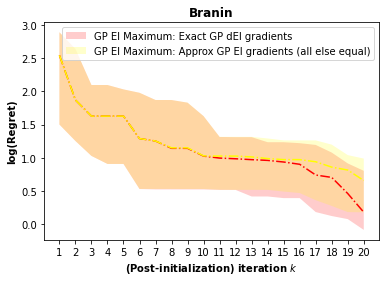

In [142]:
### Visualise!

title = func
plt.figure()

plt.plot(median_ExactSimpleRegret_exact, color = 'Red', ls='-.')
plt.plot(median_ApproxSimpleRegret_exact, color = 'Yellow', ls='-.')

xstar = np.arange(0, iters, step=1)
plt.fill_between(xstar, lower_ExactSimpleRegret_exact, upper_ExactSimpleRegret_exact, facecolor = 'Red', alpha=0.2, label='GP EI Maximum: Exact GP dEI gradients')
plt.fill_between(xstar, lower_ApproxSimpleRegret_exact, upper_ApproxSimpleRegret_exact, facecolor = 'Yellow', alpha=0.2, label='GP EI Maximum: Approx GP EI gradients (all else equal)')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualize!